# Setup

In [1]:
%matplotlib inline
import os, sys, glob, shutil
from matplotlib import pyplot as plt
import numpy as np
import torch
import h5py
from sklearn import metrics
from scipy.stats import special_ortho_group
from scipy.optimize import curve_fit
from IPython.display import Image
sys.path.append('../utils/')
import functions_for_fred as fn
import nn
import viz
import pred

In [2]:
fig_force_update_master=False

In [3]:
CLASS_NUMBER = 39
L            = 4
EPOCH_NUMBER = 160
CHECKPTH_KEY = 'cone_'
DATA_KEY     = 'class_2d_{}'.format(CLASS_NUMBER)
METADATA_KEY = 'class2D'

In [4]:
# no need to edit this cell
KEYWORD      = 'cryo_exp_{}_128x128'.format(DATA_KEY)
CHECKPT_FILE = 'cryo_exp_{}_l{}_{}epoch_{}_checkpoint.pth'.format(DATA_KEY,L,CHECKPTH_KEY,EPOCH_NUMBER)
DATASET_DIR     = '../train_val_datasets/'
METADATASET_DIR = '../datasets/exp/20181005-rib-TEM4/Sort/'
TRAINED_DIR     = '../train_vae/'
TRAIN_DATASET_PATH     = DATASET_DIR+KEYWORD+'.npy'
TRAIN_METADATASET_PATH = METADATASET_DIR+'{}_{}_sort.h5'.format(METADATA_KEY,CLASS_NUMBER)
TRAINED_CHECKPOINT     = 'epoch_'+str(EPOCH_NUMBER)+'_checkpoint.pth'
#
print('> Storing results in {}'.format(KEYWORD))
if not os.path.exists(KEYWORD):
    os.makedirs(KEYWORD)
if not os.path.exists(KEYWORD+'/train_vae'):
    os.makedirs(KEYWORD+'/train_vae')
if not os.path.isfile(KEYWORD+'/train_vae/'+TRAINED_CHECKPOINT):
    shutil.copyfile(TRAINED_DIR+CHECKPT_FILE, KEYWORD+'/train_vae/'+TRAINED_CHECKPOINT)
else:
    print('no need to copy {} again. Already found in {}/train_vae ...'.format(TRAINED_CHECKPOINT, KEYWORD))

> Storing results in cryo_exp_class_2d_39_128x128
no need to copy epoch_160_checkpoint.pth again. Already found in cryo_exp_class_2d_39_128x128/train_vae ...


# Load dataset, encoder and decoder

In [5]:
# this is juste convenient
fig_force_update=False
if fig_force_update_master:
    fig_force_update=True

dataset.shape (5119, 1, 128, 128) metadata.shape (5119, 180, 180)


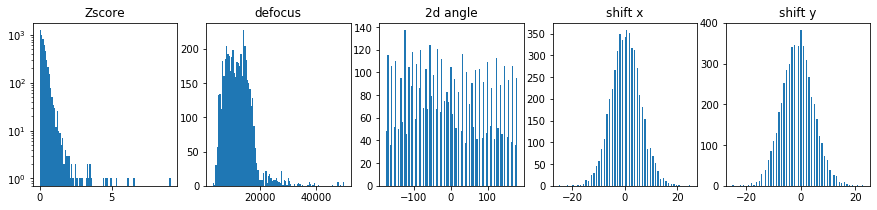

In [6]:
dataset = np.load(TRAIN_DATASET_PATH)
metadata = h5py.File(TRAIN_METADATASET_PATH, 'r')
#
Zscore       = np.array(metadata['_rlnparticleselectzscore'])
defocus_true = np.array(metadata['_rlndefocusu'])
angle_true   = np.array(metadata['_rlnanglepsi'])
tx_true      = np.array(metadata['_rlnoriginx'])
ty_true      = np.array(metadata['_rlnoriginy'])
particles    = np.expand_dims(np.array(metadata['particles']),axis=1)
print('dataset.shape {} metadata.shape {}'.format(dataset.shape, metadata['particles'].shape))
#
fig = plt.figure(figsize=(15,3))
nrow=1
ncol=5
plt.subplot(nrow,ncol,1)
plt.title('Zscore')
plt.hist(Zscore, bins=100, log=True)
plt.subplot(nrow,ncol,2)
plt.title('defocus')
plt.hist(defocus_true, bins=100, log=False)
plt.subplot(nrow,ncol,3)
plt.title('2d angle')
plt.hist(angle_true, bins=100, log=False)
plt.subplot(nrow,ncol,4)
plt.title('shift x')
plt.hist(tx_true, bins=100, log=False)
plt.subplot(nrow,ncol,5)
plt.title('shift y')
plt.hist(ty_true, bins=100, log=False)
fig.savefig(KEYWORD+'/data_v2.png')

In [7]:
mus = []
logvars = []
mus, logvars = fn.latent_projection(KEYWORD, TRAIN_DATASET_PATH, epoch_id=EPOCH_NUMBER)
print('mus.shape = {} / logvars.shape = {}'.format(mus.shape, logvars.shape))

cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth
Found checkpoint. Getting: cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth.
Loading encoder from network of architecture: conv_orig...
mus.shape = (5119, 4) / logvars.shape = (5119, 4)


# Data curation

## Parameters

In [8]:
Zscore_set        = 2
measure_threshold = 0.5
methods     =['robust_covar', 'isolation_forest', 'local_outlier_detection']
method_best = methods[1]

## Curate

AUC(robust_covar) = 0.8004268003522798 / offset=3
AUC(isolation_forest) = 0.8630309599620621 / offset=0.5
AUC(local_outlier_detection) = 0.8163471309531873 / offset=1.5
Positives: 5090 | Negatives: 29
Predicted positives: 4218 | Predicted negatives: 901
Curated dataset size: 4065


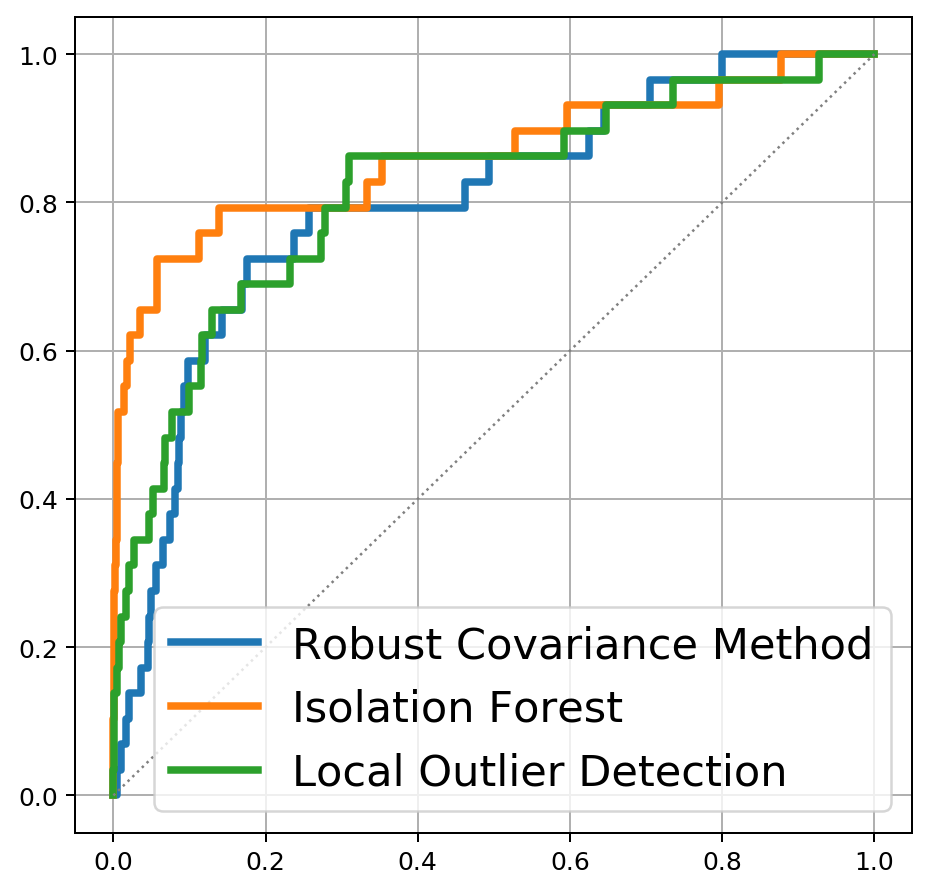

In [9]:
# Measure outlierness 
viz.plot_roc_curve(mus, Zscore, Zscore_set,
                   xlabel='',ylabel='',
                   figname=KEYWORD+'/ROC_Zscore'+str(Zscore_set))
measure, offset, assignment = pred.outlier_measure(mus, method=method_best)
print('Positives: {} | Negatives: {}'.format(np.where(Zscore<Zscore_set)[0].shape[0],np.where(Zscore>Zscore_set)[0].shape[0]))
# Keep true positives and outliers apart
index_kept = np.where(measure<measure_threshold,0,1)
mus_kept       = mus[index_kept==0,:]
logvars_kept   = logvars[index_kept==0,:]
defocus_kept   = defocus_true[index_kept==0]
angle_kept     = angle_true[index_kept==0]
tx_kept        = tx_true[index_kept==0]
ty_kept        = ty_true[index_kept==0]
Zscore_kept    = Zscore[index_kept==0]
measure_kept   = measure[index_kept==0]
particles_kept = particles[index_kept==0]
mus_outlier     = mus[index_kept==1,:]
logvars_outlier = logvars[index_kept==1,:]
defocus_outlier = defocus_true[index_kept==1]
angle_outlier   = angle_true[index_kept==1]
tx_outlier      = tx_true[index_kept==1]
ty_outlier      = ty_true[index_kept==1]
Zscore_outlier  = Zscore[index_kept==1]
measure_outlier = measure[index_kept==1]
print('Predicted positives: {} | Predicted negatives: {}'.format(mus_kept.shape[0],mus_outlier.shape[0]))
# Remove data not in desired defocus range
index_curated = np.where((defocus_kept>5000)  & (defocus_kept < 25000))[0]
mus_curated       = mus_kept[index_curated,:]
logvars_curated   = logvars_kept[index_curated,:]
defocus_curated   = defocus_kept[index_curated]
angle_curated     = angle_kept[index_curated]
tx_curated        = tx_kept[index_curated]
ty_curated        = ty_kept[index_curated]
Zscore_curated    = Zscore_kept[index_curated]
measure_curated   = measure_kept[index_curated]
particles_curated = particles_kept[index_curated]
print('Curated dataset size: {}'.format(mus_curated.shape[0]))
# Principal Component Analysis of the curated dataset
U_curated, L_curated, Vt_curated = np.linalg.svd(mus_curated - np.mean(mus_curated,axis=0), full_matrices=False)

# Parameter estimation

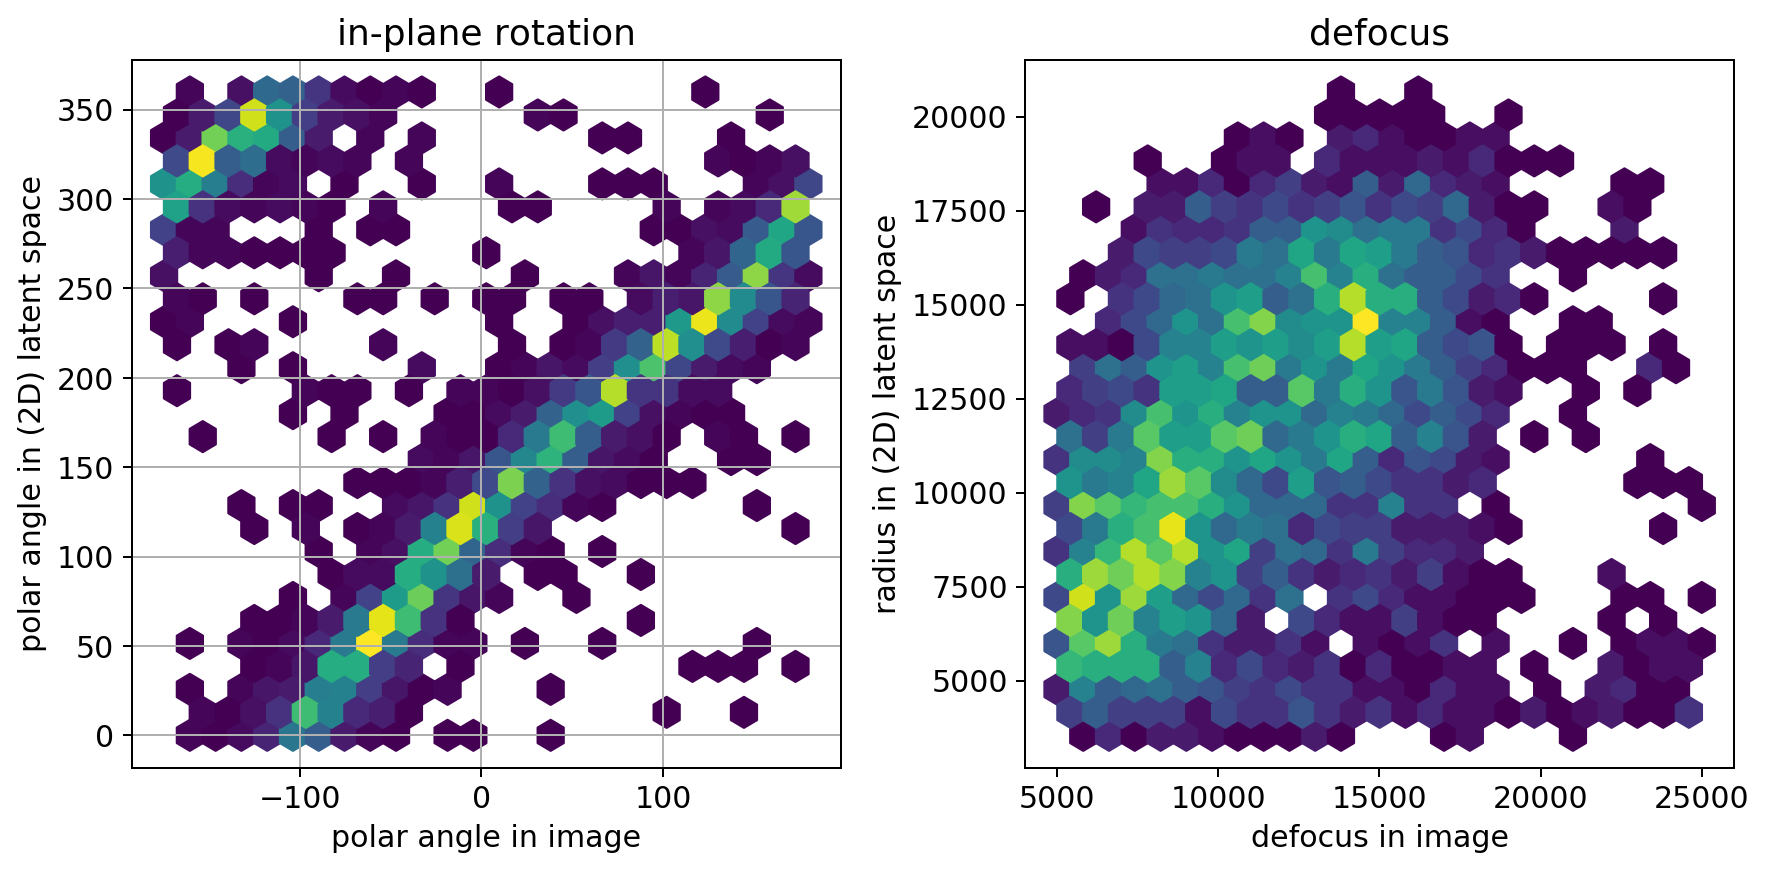

In [10]:
angle_pred, defocus_pred = pred.pred2d(U_curated[:,0:3], 
                                       angle_curated, defocus_curated, 
                                       angle_pred_sign=1.0,
                                       defocus_rescale='quartile')
viz.plot_pred2d(angle_pred, defocus_pred, angle_curated, defocus_curated)

offset: -116.0 angle RMSE = 18.576263631182005
offset: -115.75 angle RMSE = 18.565714125522796
offset: -115.5 angle RMSE = 18.558526651602843
offset: -115.25 angle RMSE = 18.554705116439457
offset: -115.0 angle RMSE = 18.554251599834224
offset: -114.75 angle RMSE = 18.55716634871909
offset: -114.5 angle RMSE = 18.563447776484534
offset: -114.25 angle RMSE = 18.57309246729418
offset: -114.0 angle RMSE = 18.586095185358488
offset: -113.75 angle RMSE = 18.602448889108853
offset: -113.5 angle RMSE = 18.622144750182862
offset: -113.25 angle RMSE = 18.645172177101887
offset: -113.0 angle RMSE = 18.6715188434937
offset: -112.75 angle RMSE = 18.701170720686477
offset: -112.5 angle RMSE = 18.734112114475487
offset: -112.25 angle RMSE = 18.770325705841334
defocus RMSE = 4475.339098238684


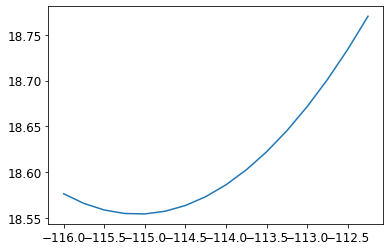

In [11]:
offset_range = np.arange(-116,-112,0.25)
defocus_pred_normalized = pred.rescale_to_zero_one(defocus_pred)
angle_RMSE_list, defocus_RMSE = pred.pred2d_mse(angle_pred, defocus_pred, 
                                                angle_curated, defocus_curated, 
                                                angle_offset_range=offset_range,
                                                angle_weight=(np.exp(defocus_pred_normalized)-1), 
                                                norm_weights=True)
plt.plot(offset_range,angle_RMSE_list)

## Exploration of the effect of logvar

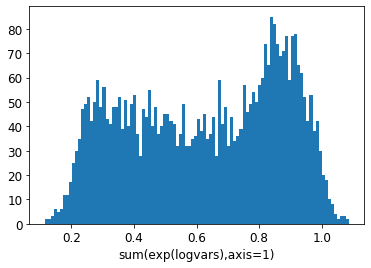

In [12]:
sumvar = np.sum(np.exp(logvars_curated),axis=1)
plt.hist(sumvar, bins=100)
plt.xlabel('sum(exp(logvars),axis=1)')
plt.show()

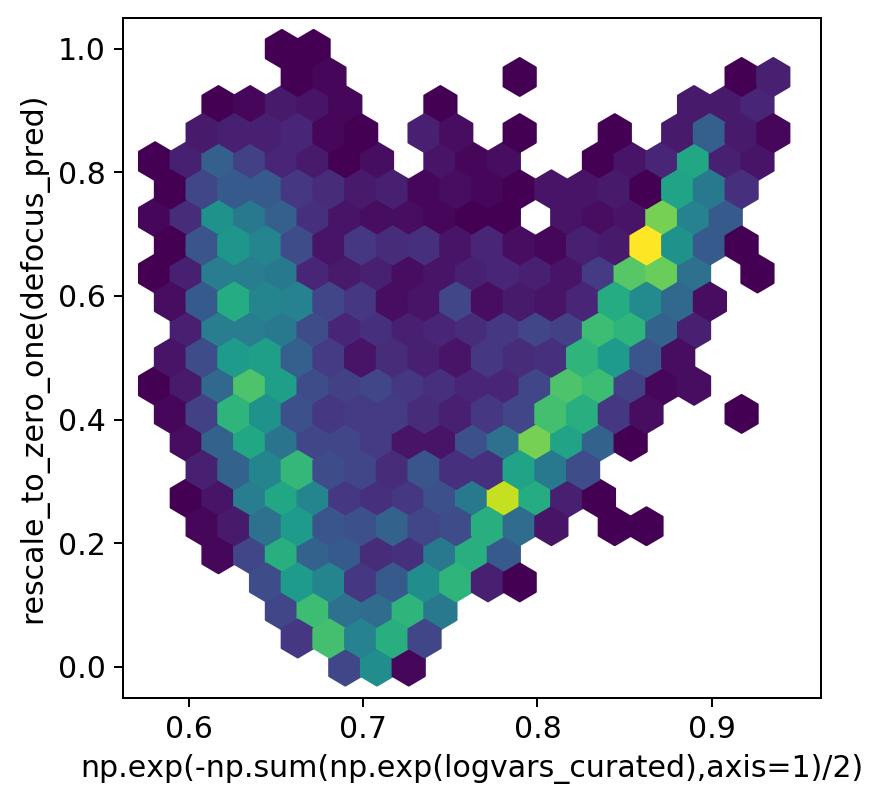

In [13]:
fig = plt.figure(figsize=(5,5), dpi=180)
plt.xlabel('np.exp(-np.sum(np.exp(logvars_curated),axis=1)/2)')
plt.ylabel('rescale_to_zero_one(defocus_pred)')
plt.hexbin(np.exp(-sumvar/2),defocus_pred_normalized, mincnt=1, gridsize=20)
plt.show()

# Figures 

## 2D reconstructions

In [14]:
nimages = 500
prtcls = particles_curated[0:nimages]
recons = []
recons = fn.reconstruction(KEYWORD, torch.Tensor(mus_curated[0:nimages,...]).cuda(), epoch_id=EPOCH_NUMBER)
print('shapes: {} {}'.format(prtcls.shape, recons.shape))

cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth
Found checkpoint. Getting: cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth.
Loading decoder from network of architecture: conv_orig...
shapes: (500, 1, 180, 180) (500, 1, 128, 128)


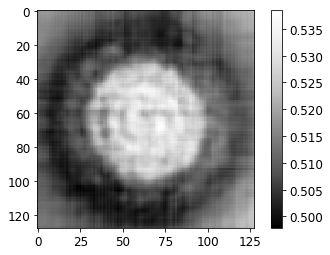

In [15]:
plt.imshow(np.mean(recons[0:nimages,0,...],axis=0), cmap='Greys_r')
plt.colorbar()

In [16]:
from scipy.ndimage import rotate
recons_rot = np.zeros(recons.shape)
prtcls_rot = np.zeros(prtcls.shape)
for i in np.arange(nimages):
    print(i,angle_curated[i])
    recons_rot[i,0,:,:] = rotate(recons[i,0,:,:], angle=-angle_curated[i], axes=(0,1), mode='wrap', reshape=False) 
    prtcls_rot[i,0,:,:] = rotate(prtcls[i,0,:,:], angle=-angle_curated[i], axes=(0,1), mode='wrap', reshape=False) 

0 146.107778
1 -78.89222
2 27.982778
3 151.732778
4 78.607778
5 -17.01722
6 -84.51722
7 27.982778
8 -22.64222
9 -17.01722
10 -112.64222
11 112.357778
12 -157.64222
13 -33.89222
14 50.482778
15 134.857778
16 -101.39222
17 -78.89222
18 106.732778
19 -112.64222
20 50.482778
21 -168.89222
22 16.732778
23 22.357778
24 123.607778
25 -168.89222
26 -22.64222
27 -45.14222
28 -123.89222
29 157.357778
30 -28.26722
31 -118.26722
32 -45.14222
33 -67.64222
34 -168.89222
35 -28.26722
36 -62.01722
37 -90.14222
38 -62.01722
39 -123.89222
40 129.232778
41 157.357778
42 -50.76722
43 -152.01722
44 11.107778
45 -17.01722
46 -39.51722
47 22.357778
48 -39.51722
49 -168.89222
50 61.732778
51 -146.39222
52 -157.64222
53 -135.14222
54 -78.89222
55 -152.01722
56 123.607778
57 174.232778
58 101.107778
59 -67.64222
60 -62.01722
61 39.232778
62 -45.14222
63 -28.26722
64 -129.51722
65 -22.64222
66 -146.39222
67 -39.51722
68 -123.89222
69 -78.89222
70 157.357778
71 -118.26722
72 -135.14222
73 33.607778
74 -11.39222
7

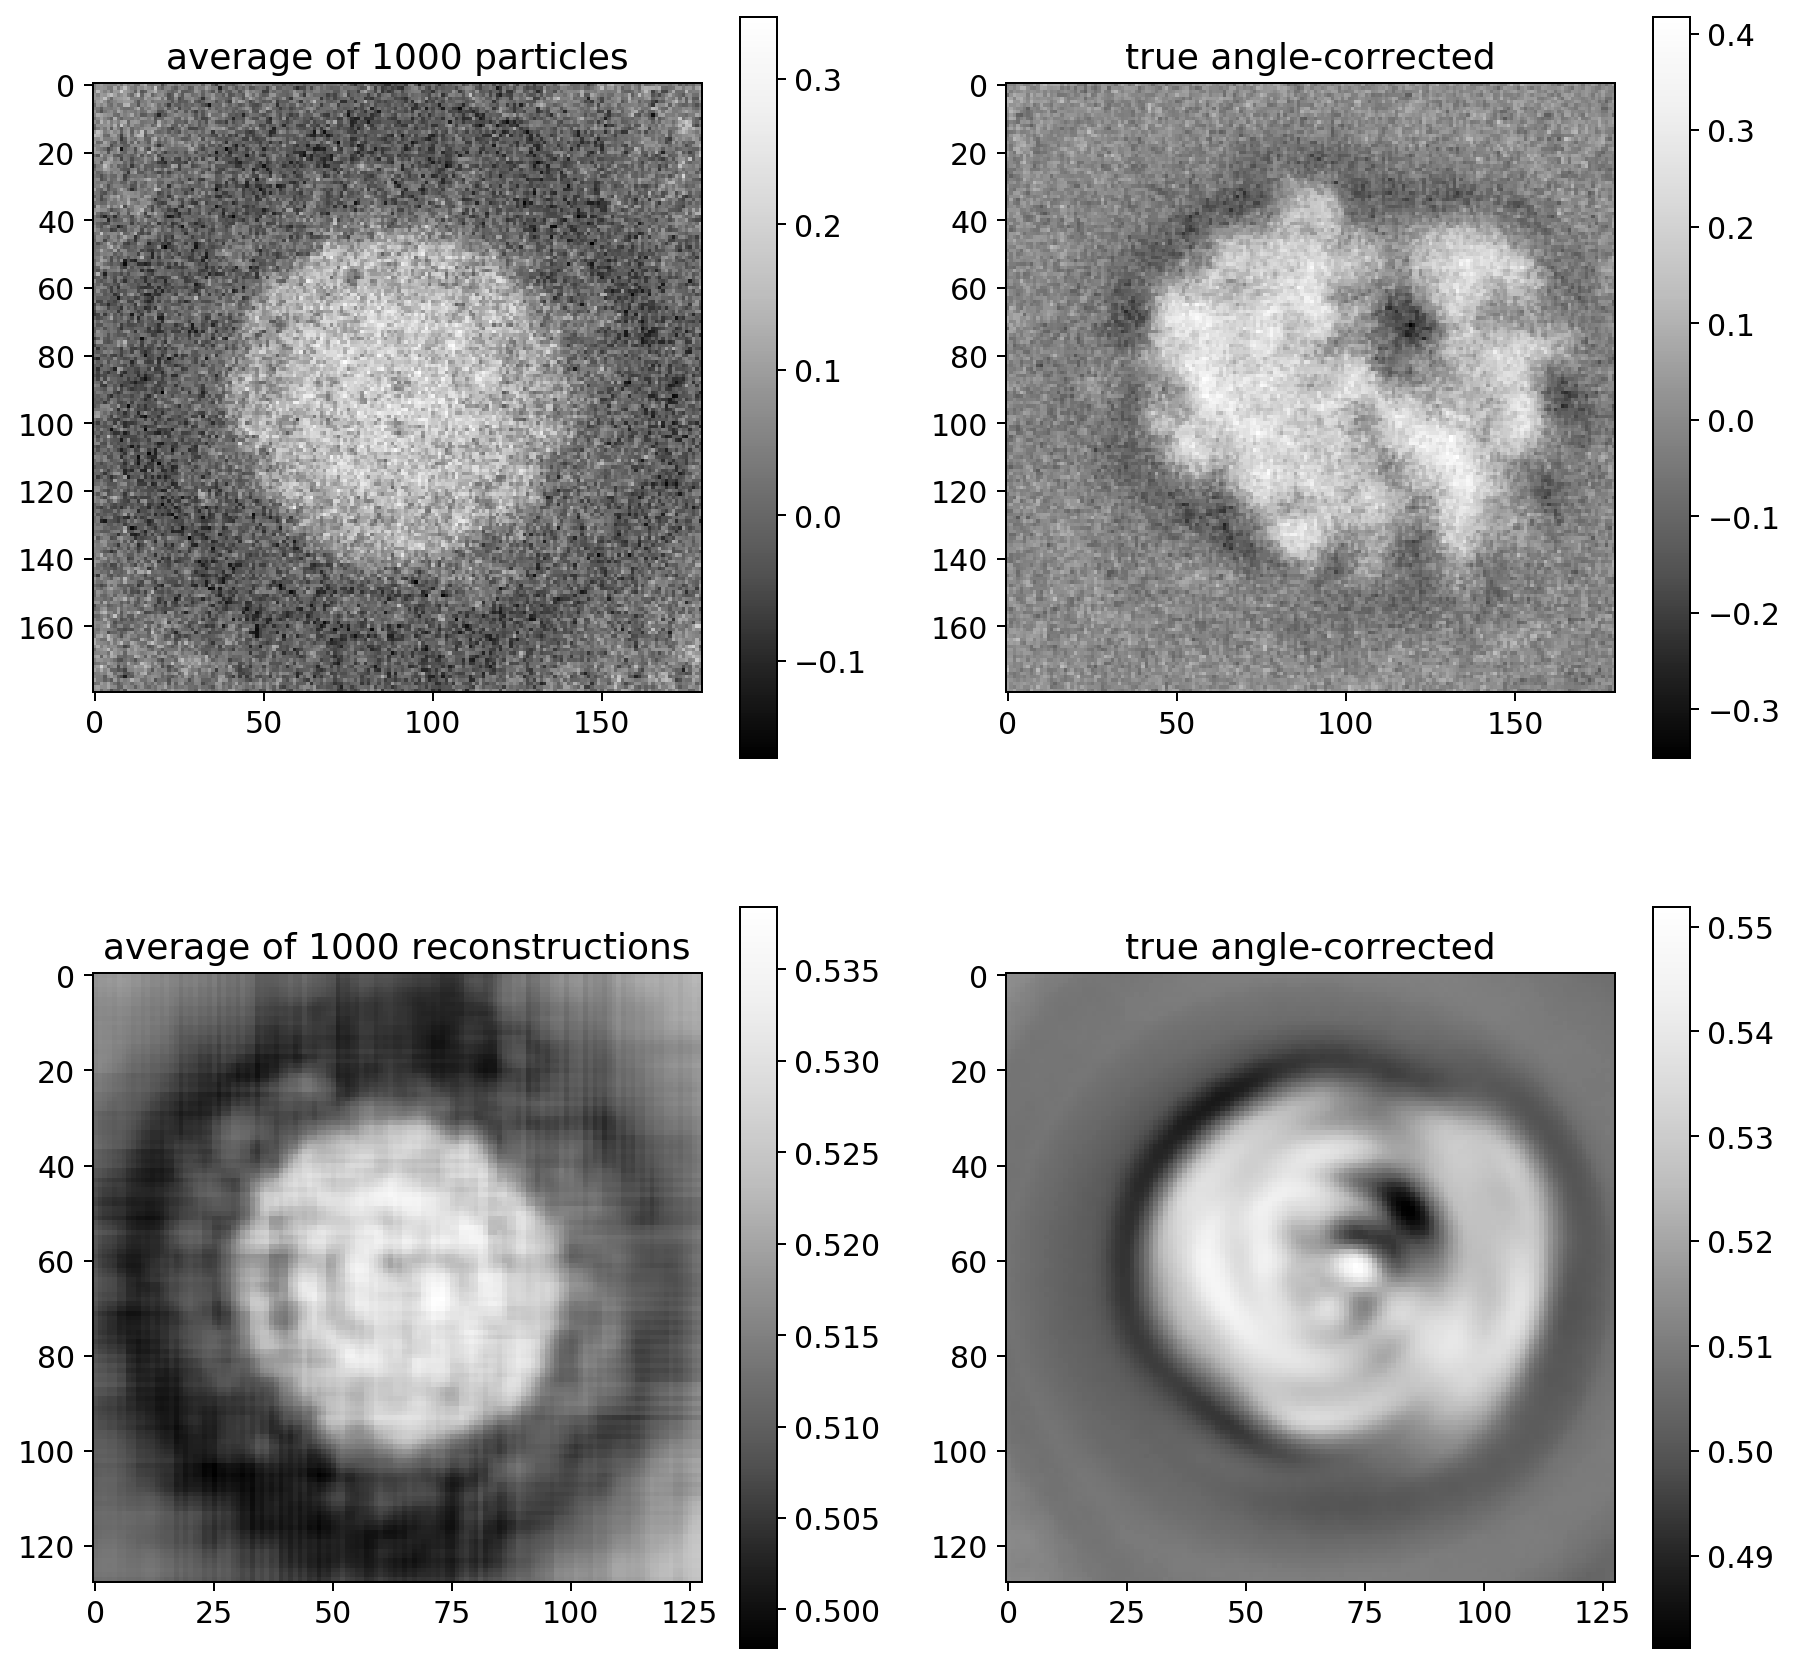

In [17]:
n=nimages
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(prtcls[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true angle-corrected')
plt.imshow(np.mean(prtcls_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recons[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true angle-corrected')
plt.imshow(np.mean(recons_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

In [30]:
from scipy.ndimage import rotate, shift
recons_rot = np.zeros(recons.shape)
prtcls_rot = np.zeros(prtcls.shape)
for i in np.arange(nimages):
    prtcls_shift = shift(prtcls[i,0,:,:], shift=((-tx_curated[i],-ty_curated[i])),mode='wrap')
    recons_shift = shift(recons[i,0,:,:], shift=((-tx_curated[i],-ty_curated[i])),mode='wrap')
    recons_rot[i,0,:,:] = rotate(recons_shift, angle=-angle_curated[i], axes=(0,1), mode='wrap', reshape=False) 
    prtcls_rot[i,0,:,:] = rotate(prtcls_shift, angle=-angle_curated[i], axes=(0,1), mode='wrap', reshape=False) 

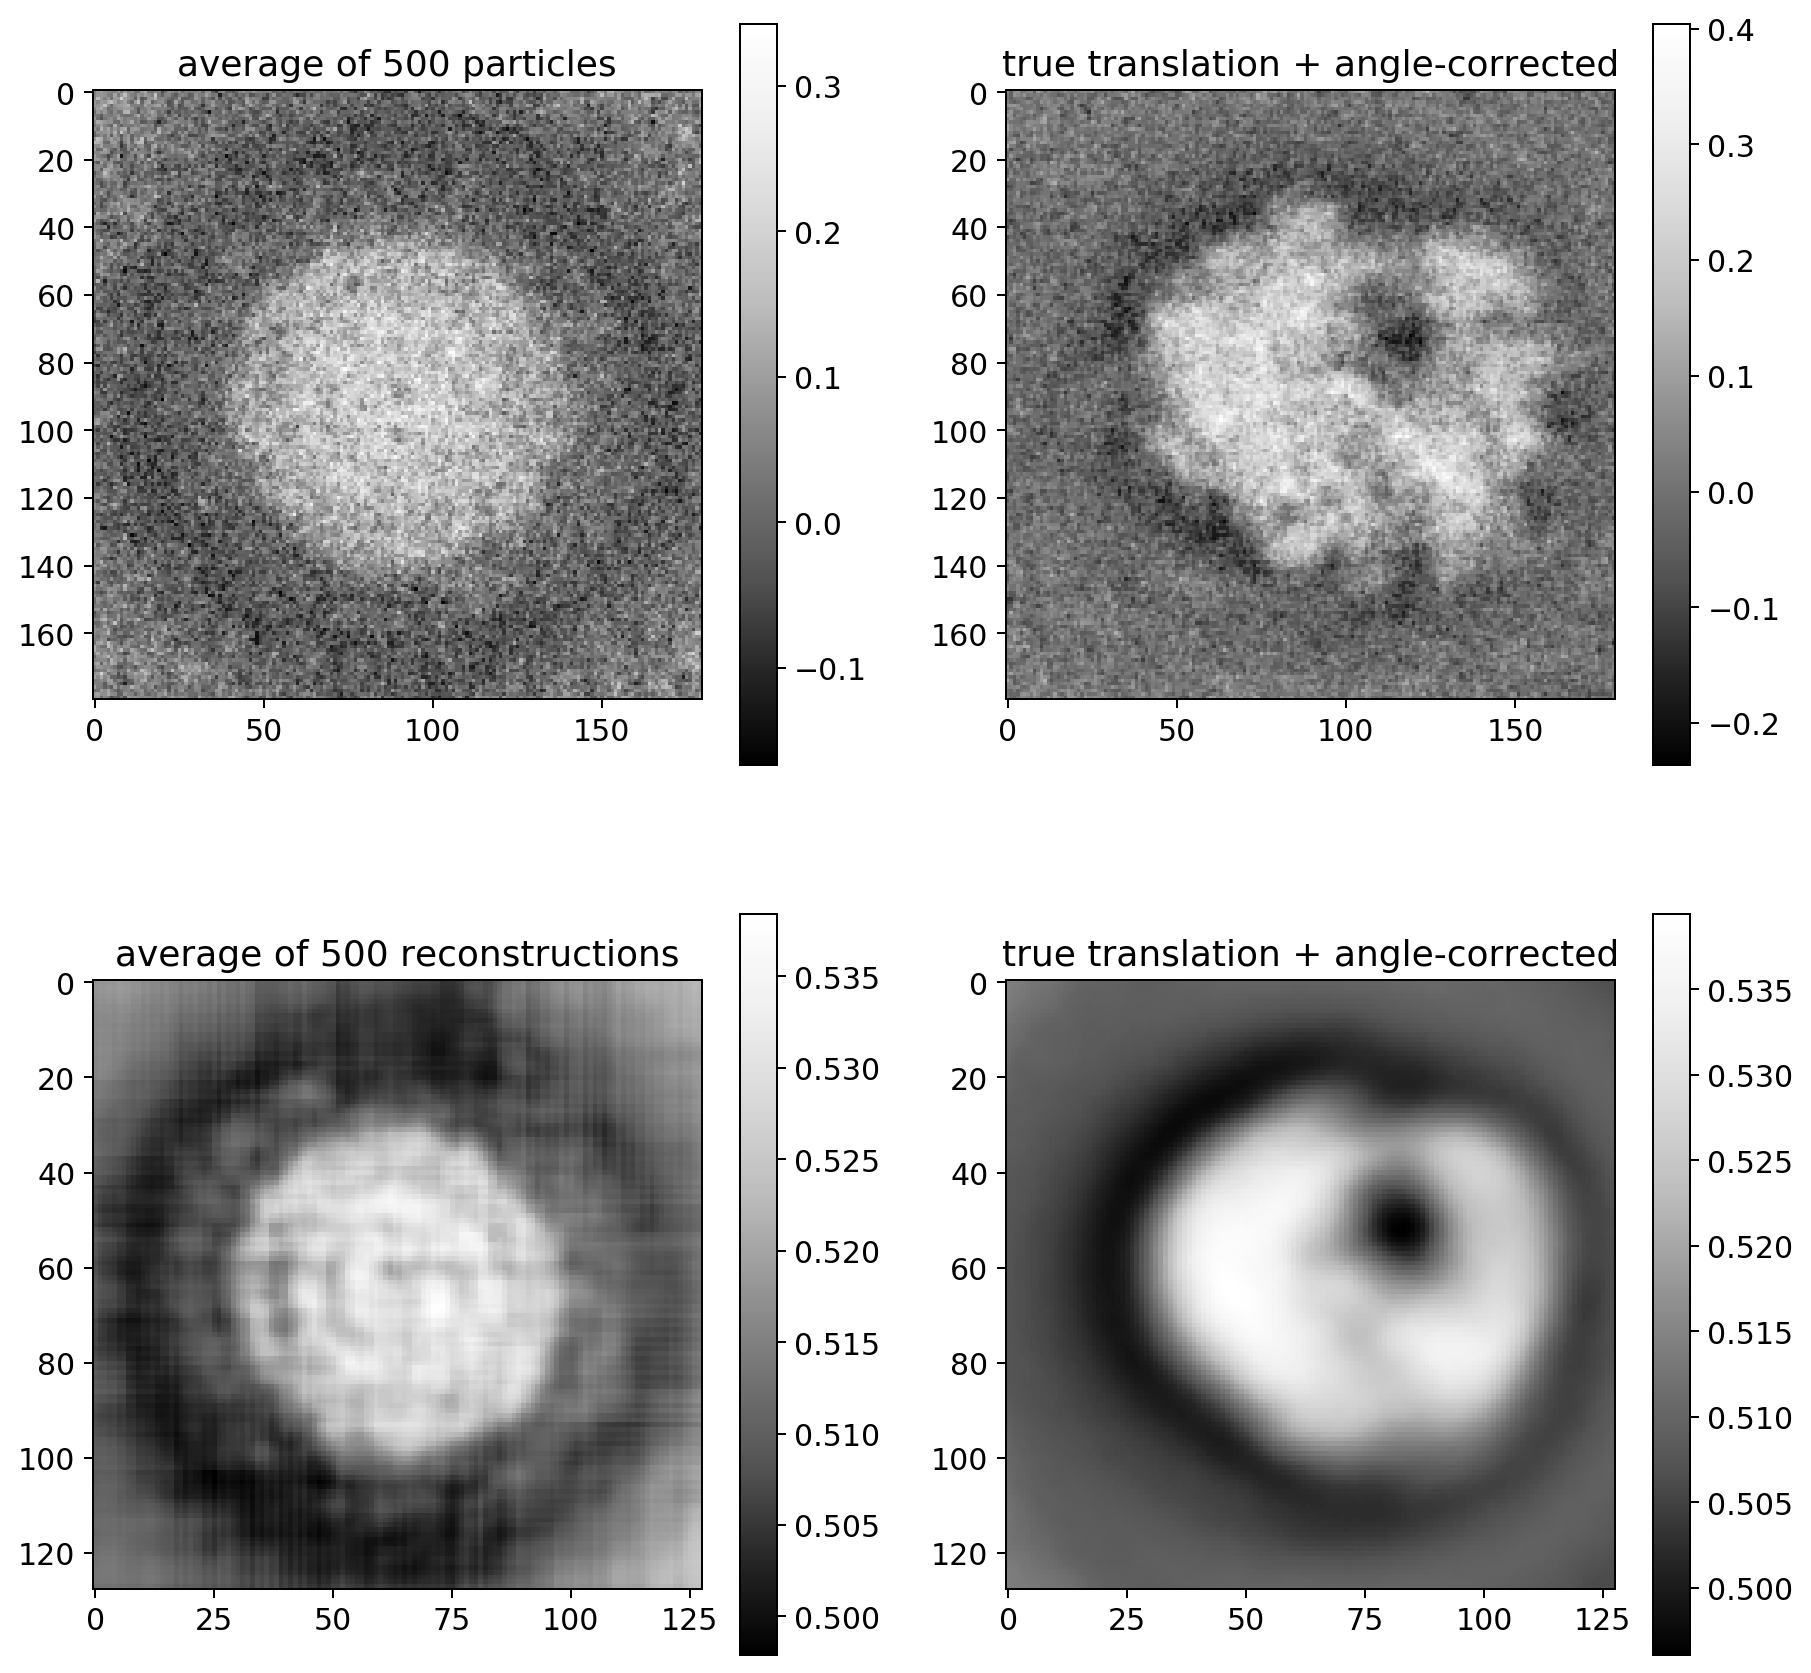

In [31]:
n=nimages
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of {} particles'.format(n))
plt.imshow(np.mean(prtcls[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true translation + angle-corrected')
plt.imshow(np.mean(prtcls_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of {} reconstructions'.format(n))
plt.imshow(np.mean(recons[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true translation + angle-corrected')
plt.imshow(np.mean(recons_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

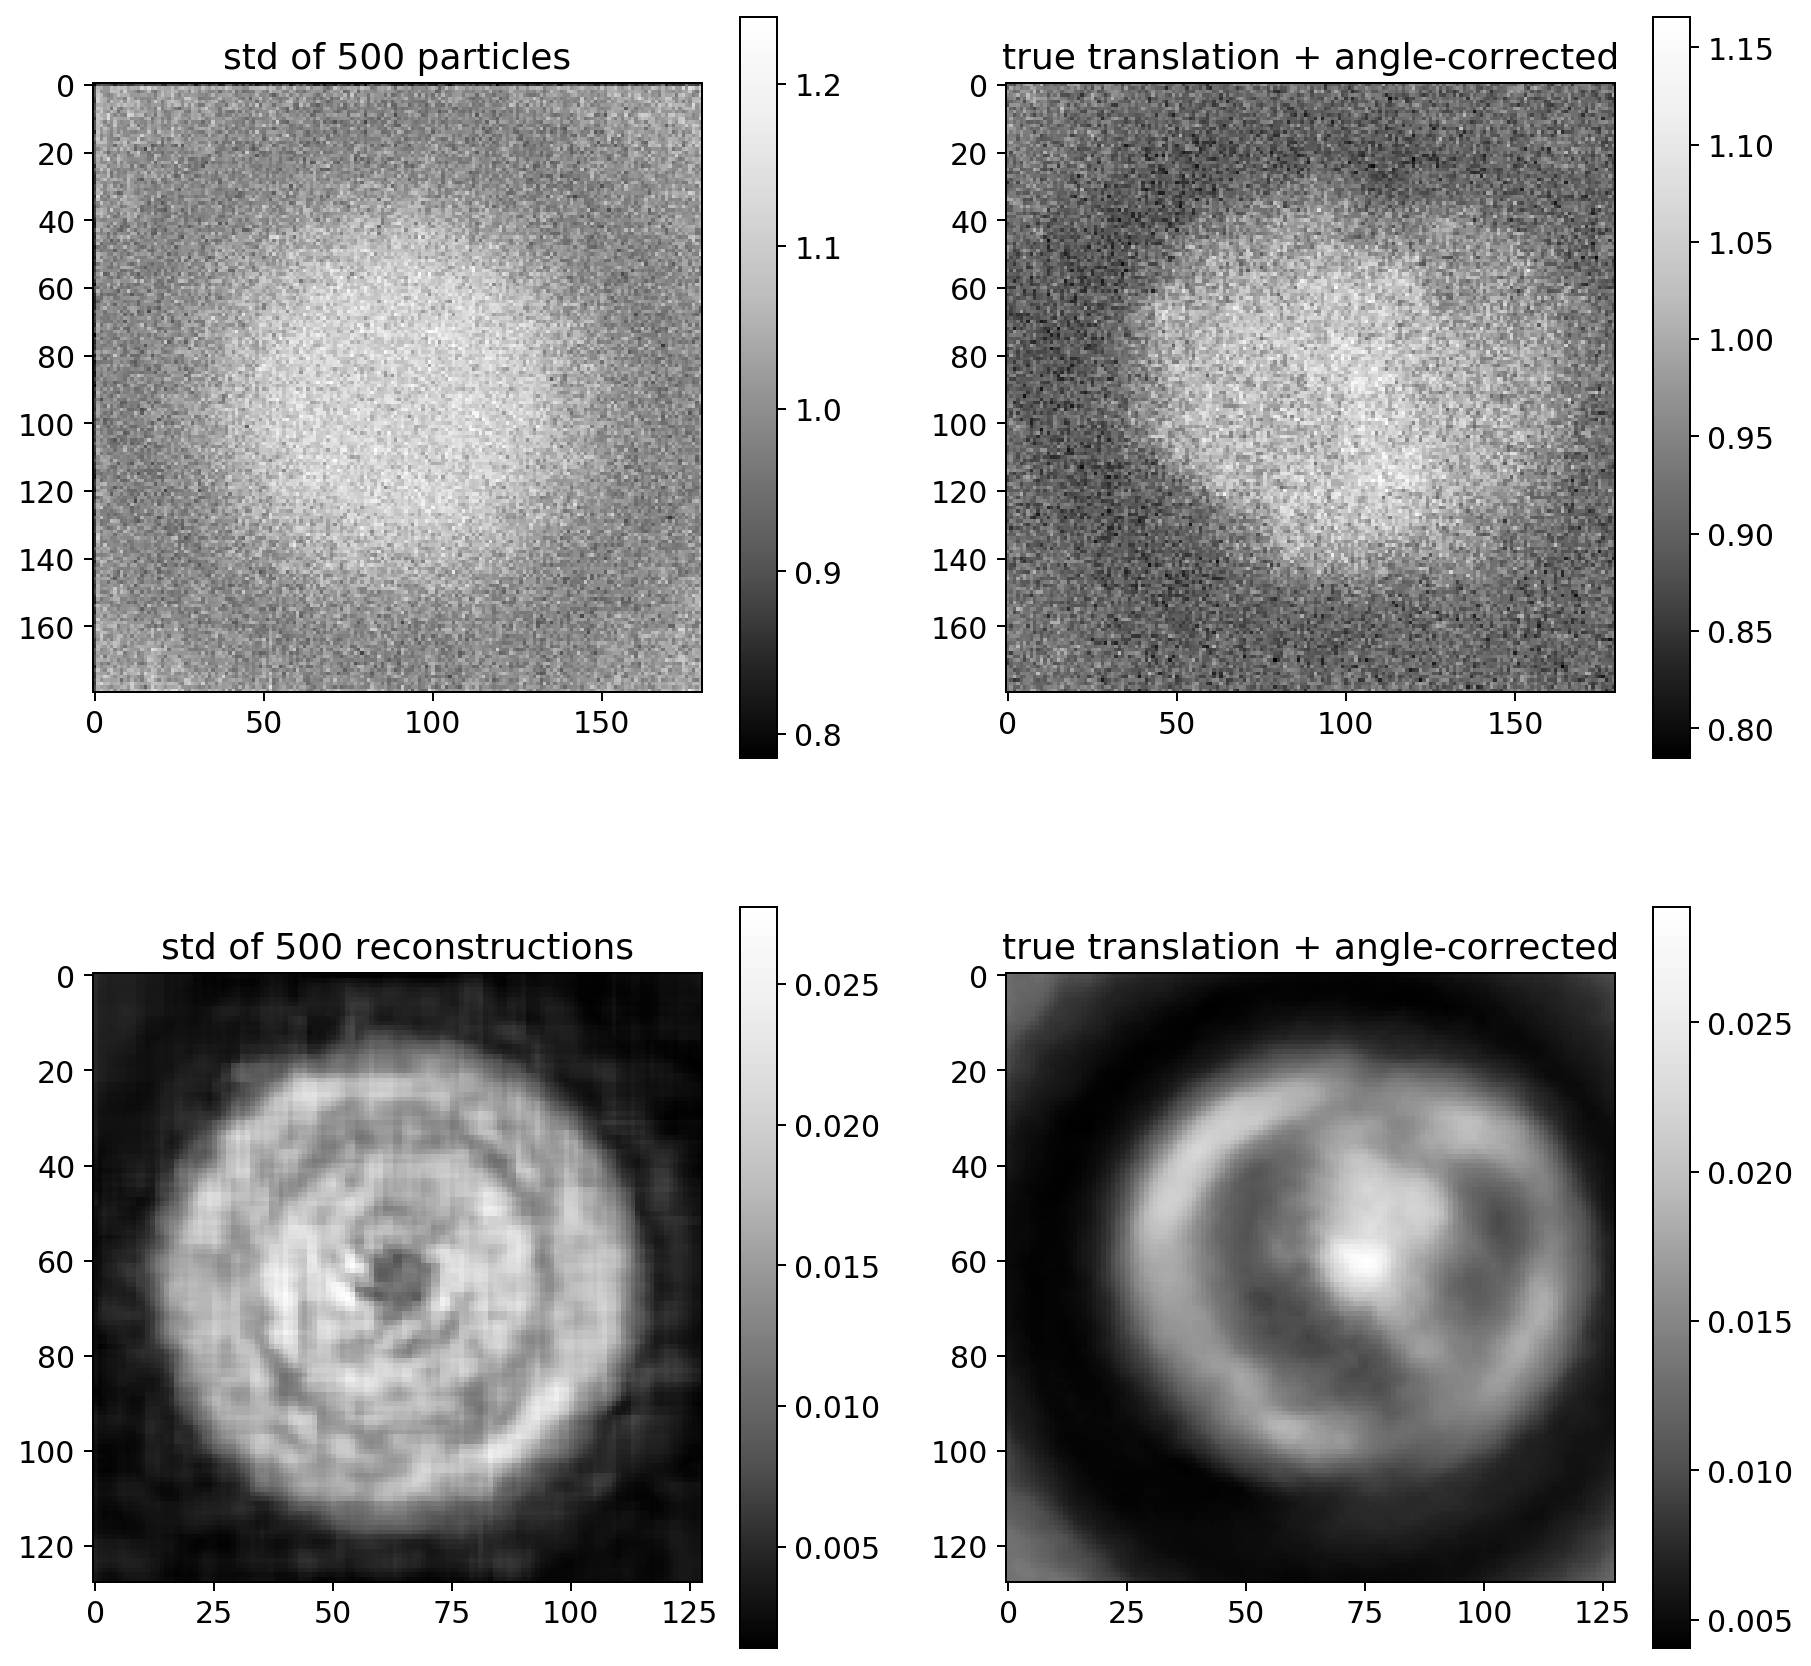

In [33]:
n=nimages
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('std of {} particles'.format(n))
plt.imshow(np.std(prtcls[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true translation + angle-corrected')
plt.imshow(np.std(prtcls_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('std of {} reconstructions'.format(n))
plt.imshow(np.std(recons[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true translation + angle-corrected')
plt.imshow(np.std(recons_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

In [26]:
from scipy.ndimage import rotate
recons_rot = np.zeros(recons.shape)
prtcls_rot = np.zeros(prtcls.shape)
for i in np.arange(nimages):
    print(i,angle_curated[i])
    recons_rot[i,0,:,:] = rotate(recons[i,0,:,:], angle=-angle_pred[i], axes=(0,1), mode='wrap', reshape=False) 
    prtcls_rot[i,0,:,:] = rotate(prtcls[i,0,:,:], angle=-angle_pred[i], axes=(0,1), mode='wrap', reshape=False) 

0 146.107778
1 -78.89222
2 27.982778
3 151.732778
4 78.607778
5 -17.01722
6 -84.51722
7 27.982778
8 -22.64222
9 -17.01722
10 -112.64222
11 112.357778
12 -157.64222
13 -33.89222
14 50.482778
15 134.857778
16 -101.39222
17 -78.89222
18 106.732778
19 -112.64222
20 50.482778
21 -168.89222
22 16.732778
23 22.357778
24 123.607778
25 -168.89222
26 -22.64222
27 -45.14222
28 -123.89222
29 157.357778
30 -28.26722
31 -118.26722
32 -45.14222
33 -67.64222
34 -168.89222
35 -28.26722
36 -62.01722
37 -90.14222
38 -62.01722
39 -123.89222
40 129.232778
41 157.357778
42 -50.76722
43 -152.01722
44 11.107778
45 -17.01722
46 -39.51722
47 22.357778
48 -39.51722
49 -168.89222
50 61.732778
51 -146.39222
52 -157.64222
53 -135.14222
54 -78.89222
55 -152.01722
56 123.607778
57 174.232778
58 101.107778
59 -67.64222
60 -62.01722
61 39.232778
62 -45.14222
63 -28.26722
64 -129.51722
65 -22.64222
66 -146.39222
67 -39.51722
68 -123.89222
69 -78.89222
70 157.357778
71 -118.26722
72 -135.14222
73 33.607778
74 -11.39222
7

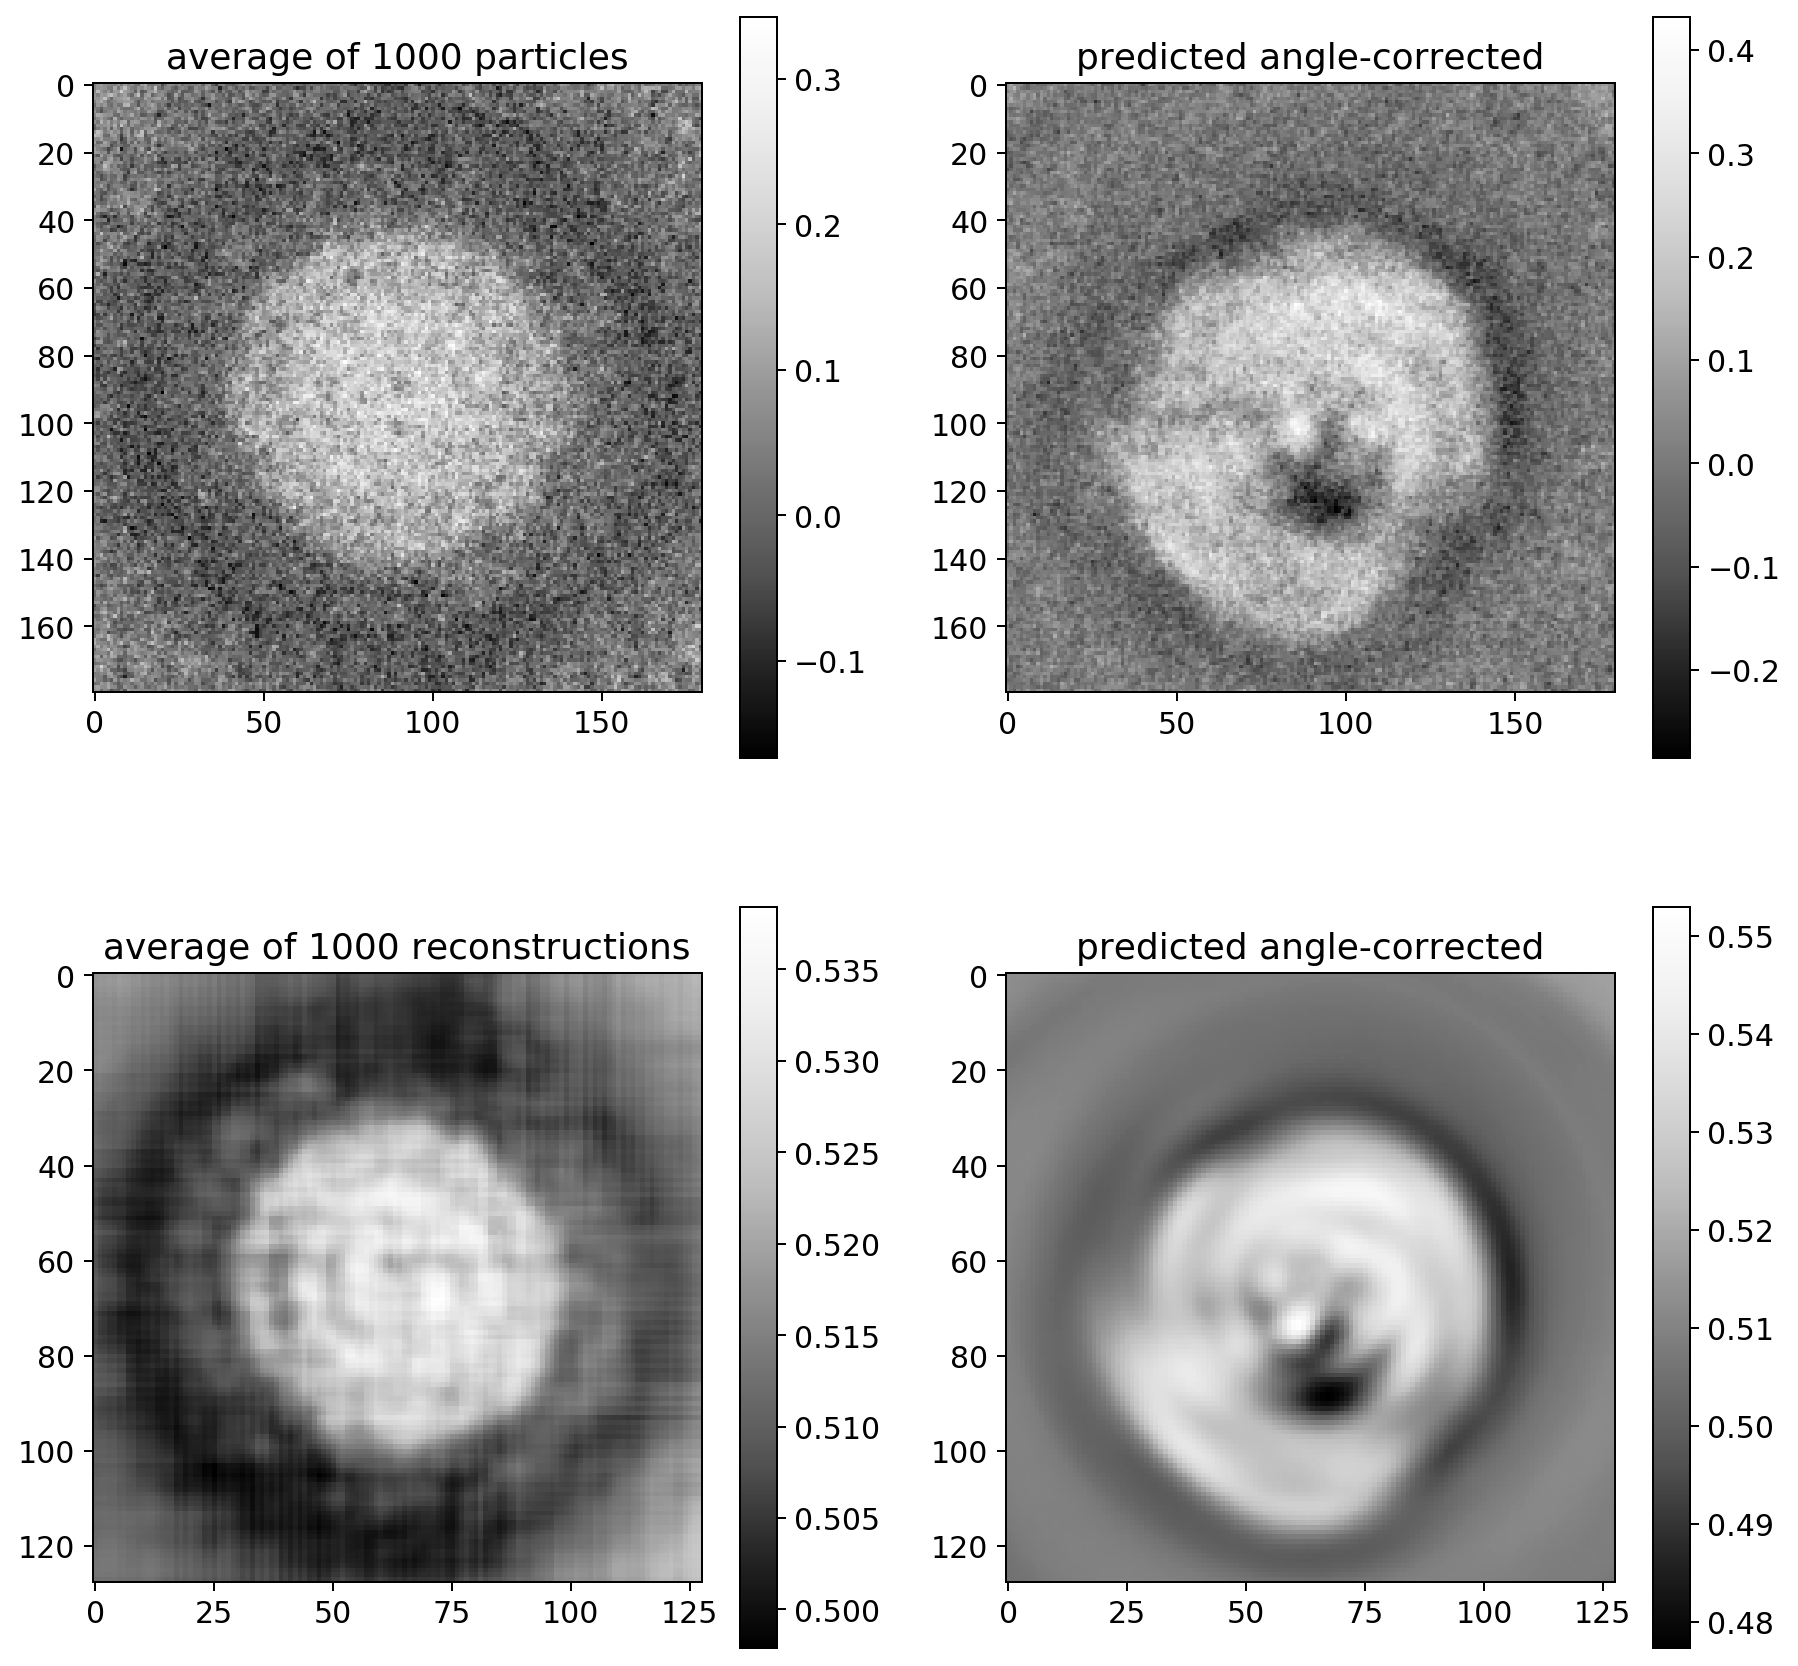

In [27]:
n=nimages
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(prtcls[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('predicted angle-corrected')
plt.imshow(np.mean(prtcls_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recons[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('predicted angle-corrected')
plt.imshow(np.mean(recons_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

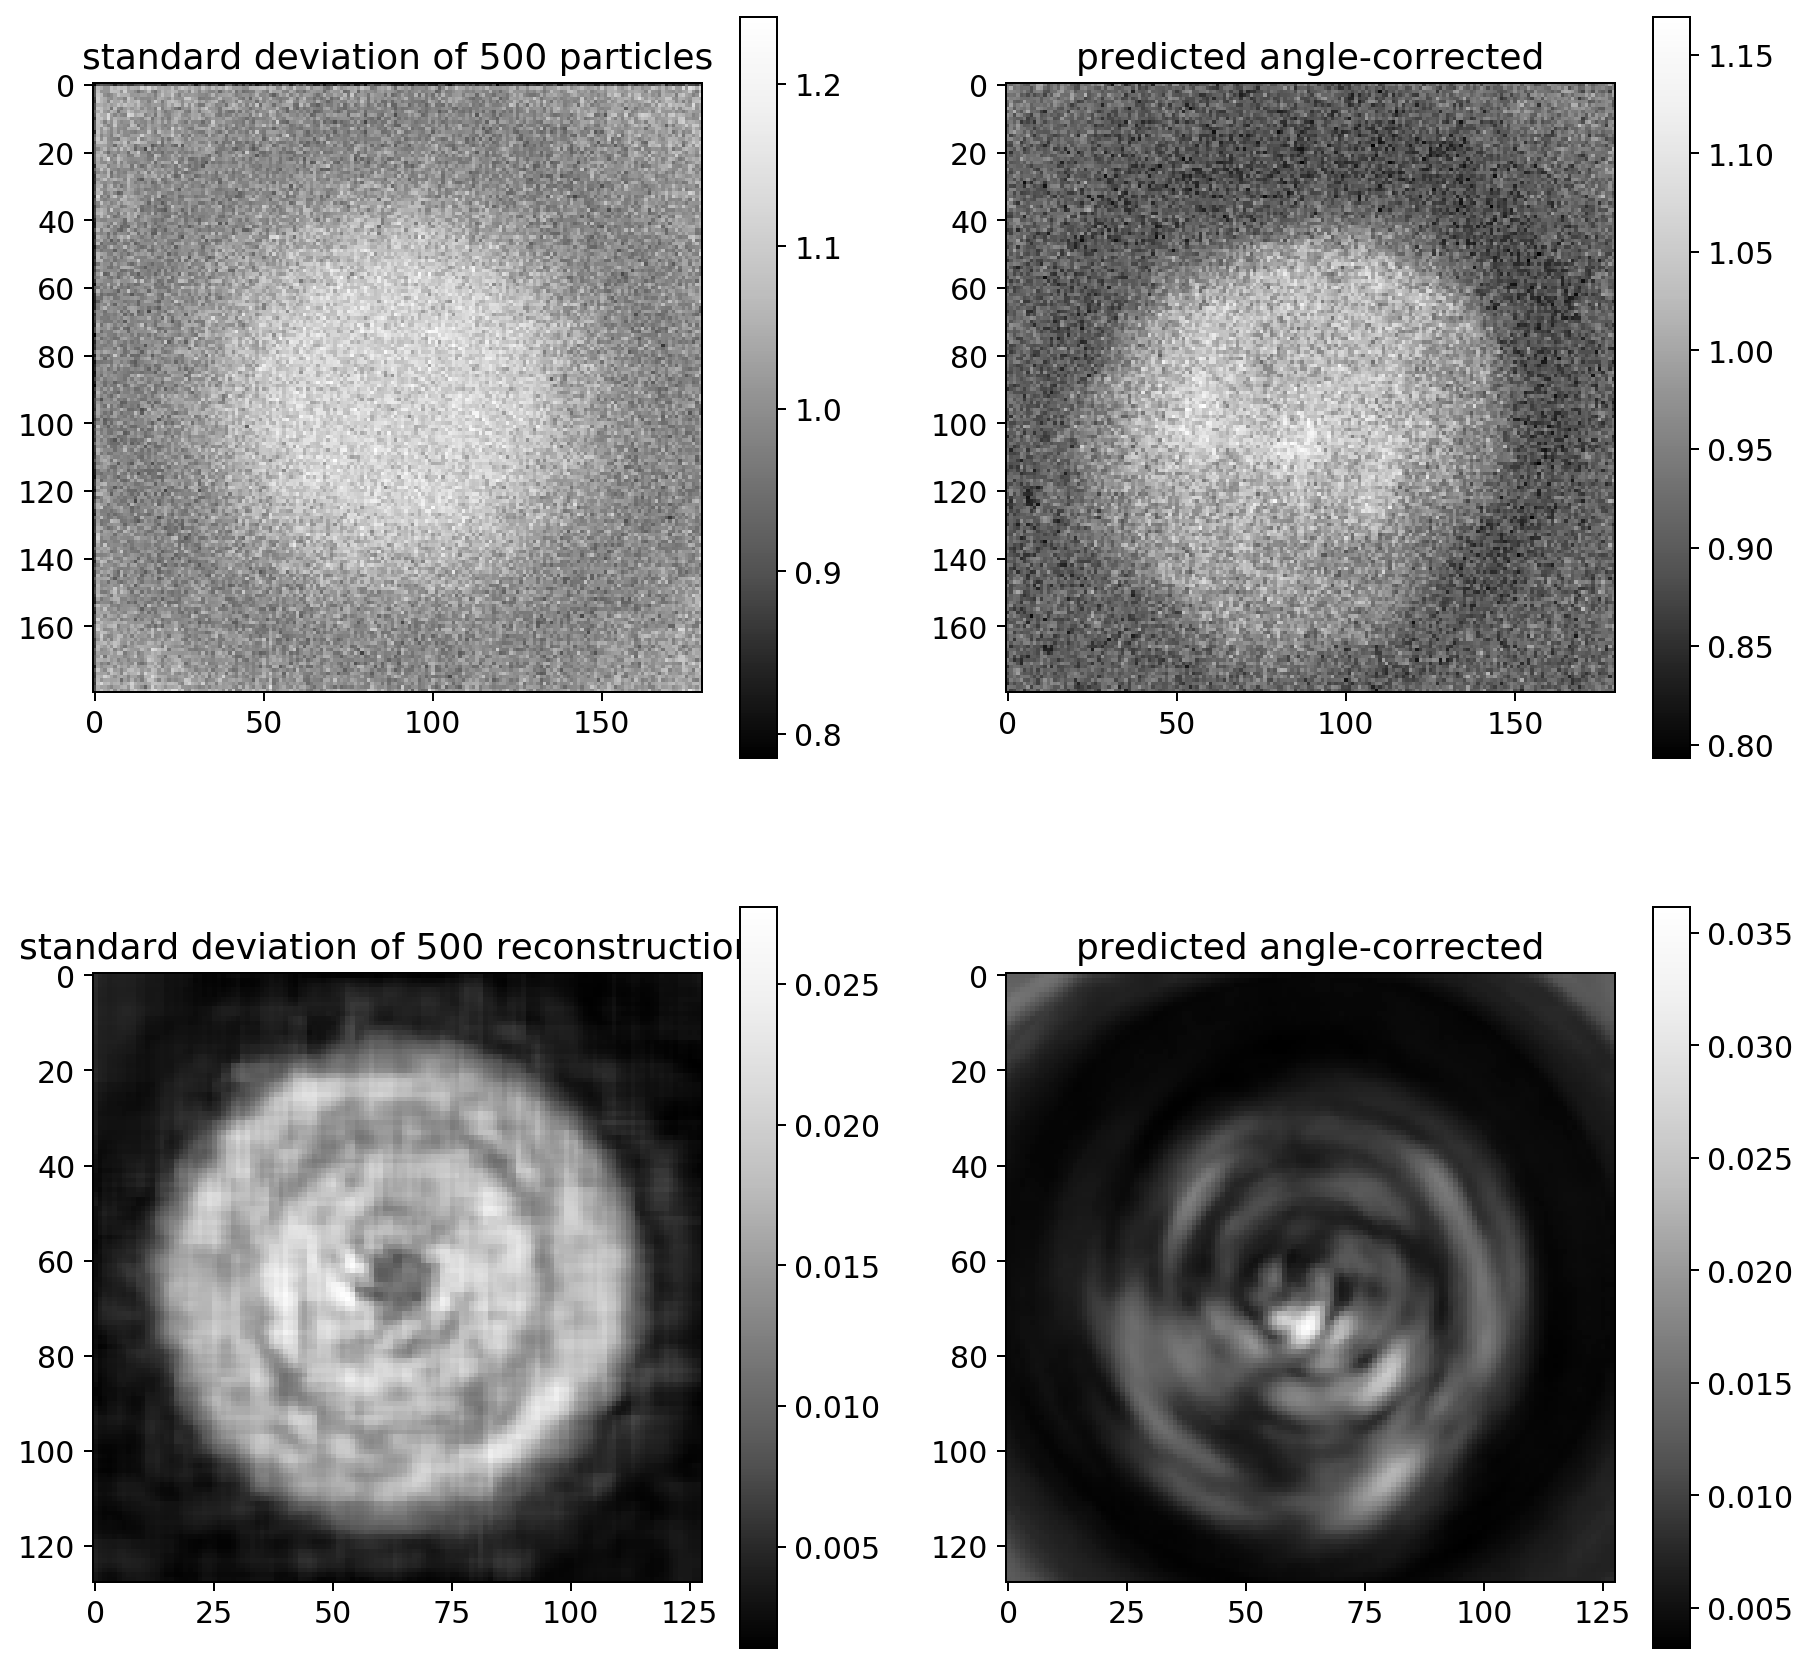

In [29]:
n=nimages
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('standard deviation of {} particles'.format(n))
plt.imshow(np.std(prtcls[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('predicted angle-corrected')
plt.imshow(np.std(prtcls_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('standard deviation of {} reconstructions'.format(n))
plt.imshow(np.std(recons[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('predicted angle-corrected')
plt.imshow(np.std(recons_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

## Representative True positive, etc.

In [ ]:
index_positive = np.where(Zscore<Zscore_set)[0]
index_negative = np.where(Zscore>Zscore_set)[0]
#
index_true_positive  = np.intersect1d(index_positive, np.where(index_kept==0))
index_false_positive = np.intersect1d(index_negative, np.where(index_kept==0))
index_true_negative  = np.intersect1d(index_negative, np.where(index_kept==1))
index_false_negative = np.intersect1d(index_positive, np.where(index_kept==1))
print('TP:{} FP:{} TN:{} FN:{}'.format(index_true_positive .shape[0], 
                           index_false_positive.shape[0], 
                           index_true_negative.shape[0],
                           index_false_negative.shape[0]
                          )
     )
particle_images = np.array(metadata['particles'])

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(np.mean(particle_images[index_false_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,2)
plt.imshow(np.mean(particle_images[index_true_positive[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,3)
plt.imshow(np.mean(particle_images[index_true_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,4)
plt.imshow(np.mean(particle_images[index_false_positive[0:6],...],axis=0), cmap='Greys_r')

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(np.std(particle_images[index_false_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,2)
plt.imshow(np.std(particle_images[index_true_positive[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,3)
plt.imshow(np.std(particle_images[index_true_negative[0:23],...],axis=0), cmap='Greys_r')
plt.subplot(2,2,4)
plt.imshow(np.std(particle_images[index_false_positive[0:6],...],axis=0), cmap='Greys_r')

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_positive[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_negative[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_positive[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,8))
for i in np.arange(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_negative[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in np.arange(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_negative[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in np.arange(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_positive[i],...], cmap='Greys_r')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(18):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_negative[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_true_negatives.png')

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(18):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_true_positive[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_true_positives.png')

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(18):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_negative[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_false_negatives.png')

In [ ]:
fig = plt.figure(figsize=(12,24), dpi=180)
for i in np.arange(6):
    plt.subplot(6,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_false_positive[i],...], cmap='Greys_r')
plt.tight_layout()
fig.savefig(KEYWORD+'/particles_false_positives.png')

## Trajectories in latent space

In [ ]:
recon = []
recon = fn.reconstruction(KEYWORD, torch.Tensor(mus_curated[0:500,...]).cuda(), epoch_id=EPOCH_NUMBER)
recon.shape

In [ ]:
r, theta = pred.cart2pol(U_curated[0:500,0], U_curated[0:500,1])
#
index_theta_ordered = np.argsort(theta)
index_r_shell       = np.where((r>0.027) & (r<0.03))[0]
theta_sorted, index_gif, index_r = np.intersect1d(index_theta_ordered, index_r_shell, return_indices=True)
#
fig = plt.figure
plt.subplot(2,2,1)
plt.plot(index_theta_ordered)
plt.subplot(2,2,2)
plt.plot(index_r_shell)
plt.subplot(2,2,3)
plt.plot(index_theta_ordered[index_gif])
plt.subplot(2,2,4)
plt.plot(index_r_shell[index_r])
plt.show()
#
fig = plt.figure()
plt.plot(theta[index_theta_ordered])
plt.plot(index_gif,theta[index_theta_ordered[index_gif]], 'X')
plt.show()
#
for i in np.argsort(index_gif):
    print('{:03d} {:03d} {:.02f}'.format(index_gif[i], index_theta_ordered[index_gif[i]], theta[index_theta_ordered[index_gif[i]]]))

In [ ]:
j=0
jcnt=0
for i in np.argsort(index_gif): #np.arange(index_r_shell.shape[0]):
    if(np.mod(j,2)==0):
        jcnt+=1
        print(i,  theta[index_theta_ordered[index_gif[i]]])
        visualize_simple(np.expand_dims(particle_images,axis=1)[index_curated[0:500],...],
                      recon,
                      U_curated[:,0:2], U_curated[:,0:2],
                      angle_curated, defocus_curated,
                      iframe=index_theta_ordered[index_gif[i]],
                      cmap1='twilight',
                      show_1dpsd=False, show_3dpsd=False,
                      figname=KEYWORD+'/gif/gif1/rotate_{:03d}.png'.format(jcnt))
    j+=1

In [ ]:
fig = plt.figure(figsize=(12,36), dpi=180)
for i in np.arange(0,12,2):
    plt.subplot(6,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recon[i,0,...], cmap='Greys_r')
    plt.subplot(6,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(particle_images[index_curated[i],...], cmap='Greys_r')
plt.tight_layout()
#fig.savefig(KEYWORD+'/particles_false_negatives.png')

## in-plane rotation correction

In [25]:
list(metadata.keys())

['_rlnamplitudecontrast',
 '_rlnanglepsi',
 '_rlnanglerot',
 '_rlnangletilt',
 '_rlnautopickfigureofmerit',
 '_rlnclassnumber',
 '_rlncoordinatex',
 '_rlncoordinatey',
 '_rlnctfbfactor',
 '_rlnctffigureofmerit',
 '_rlnctfmaxresolution',
 '_rlnctfscalefactor',
 '_rlndefocusangle',
 '_rlndefocusu',
 '_rlndefocusv',
 '_rlndetectorpixelsize',
 '_rlngroupnumber',
 '_rlnimagename',
 '_rlnloglikelicontribution',
 '_rlnmagnification',
 '_rlnmaxvalueprobdistribution',
 '_rlnmicrographname',
 '_rlnnormcorrection',
 '_rlnnrofsignificantsamples',
 '_rlnoriginx',
 '_rlnoriginy',
 '_rlnparticleselectzscore',
 '_rlnphaseshift',
 '_rlnsphericalaberration',
 '_rlnvoltage',
 'particles']

In [13]:
particle_images = np.array(metadata['particles'])

In [87]:
recon = []
recon = fn.reconstruction(KEYWORD, torch.Tensor(mus_curated[0:1000,...]).cuda(), epoch_id=EPOCH_NUMBER)
recon.shape

cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth
Found checkpoint. Getting: cryo_exp_class_2d_39_128x128/train_vae/epoch_160_checkpoint.pth.
Loading decoder from network of architecture: conv_orig...


(1000, 1, 128, 128)

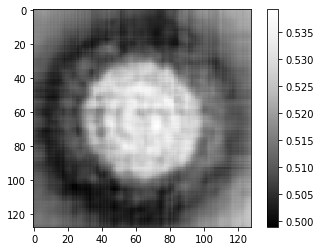

In [11]:
plt.imshow(np.mean(recon[0:500,0,...],axis=0), cmap='Greys_r')
plt.colorbar()

In [15]:
particles_dataset = np.expand_dims(particle_images,axis=1)[index_curated[0:1000],...]
particles_dataset.shape

(1000, 1, 180, 180)

In [88]:
from scipy.ndimage import rotate
recon_rot = np.zeros(recon.shape)
particles_rot = np.zeros(particles_dataset.shape)
for i in np.arange(1000):
    #print(i,angle_curated[i])
    recon_rot[i,0,:,:] = rotate(recon[i,0,:,:],angle=-angle_curated[i],axes=(0,1),mode='wrap', reshape=False) 
    particles_rot[i,0,:,:] = rotate(particles_dataset[i,0,:,:],angle=-angle_curated[i],axes=(0,1), mode='wrap', reshape=False) 

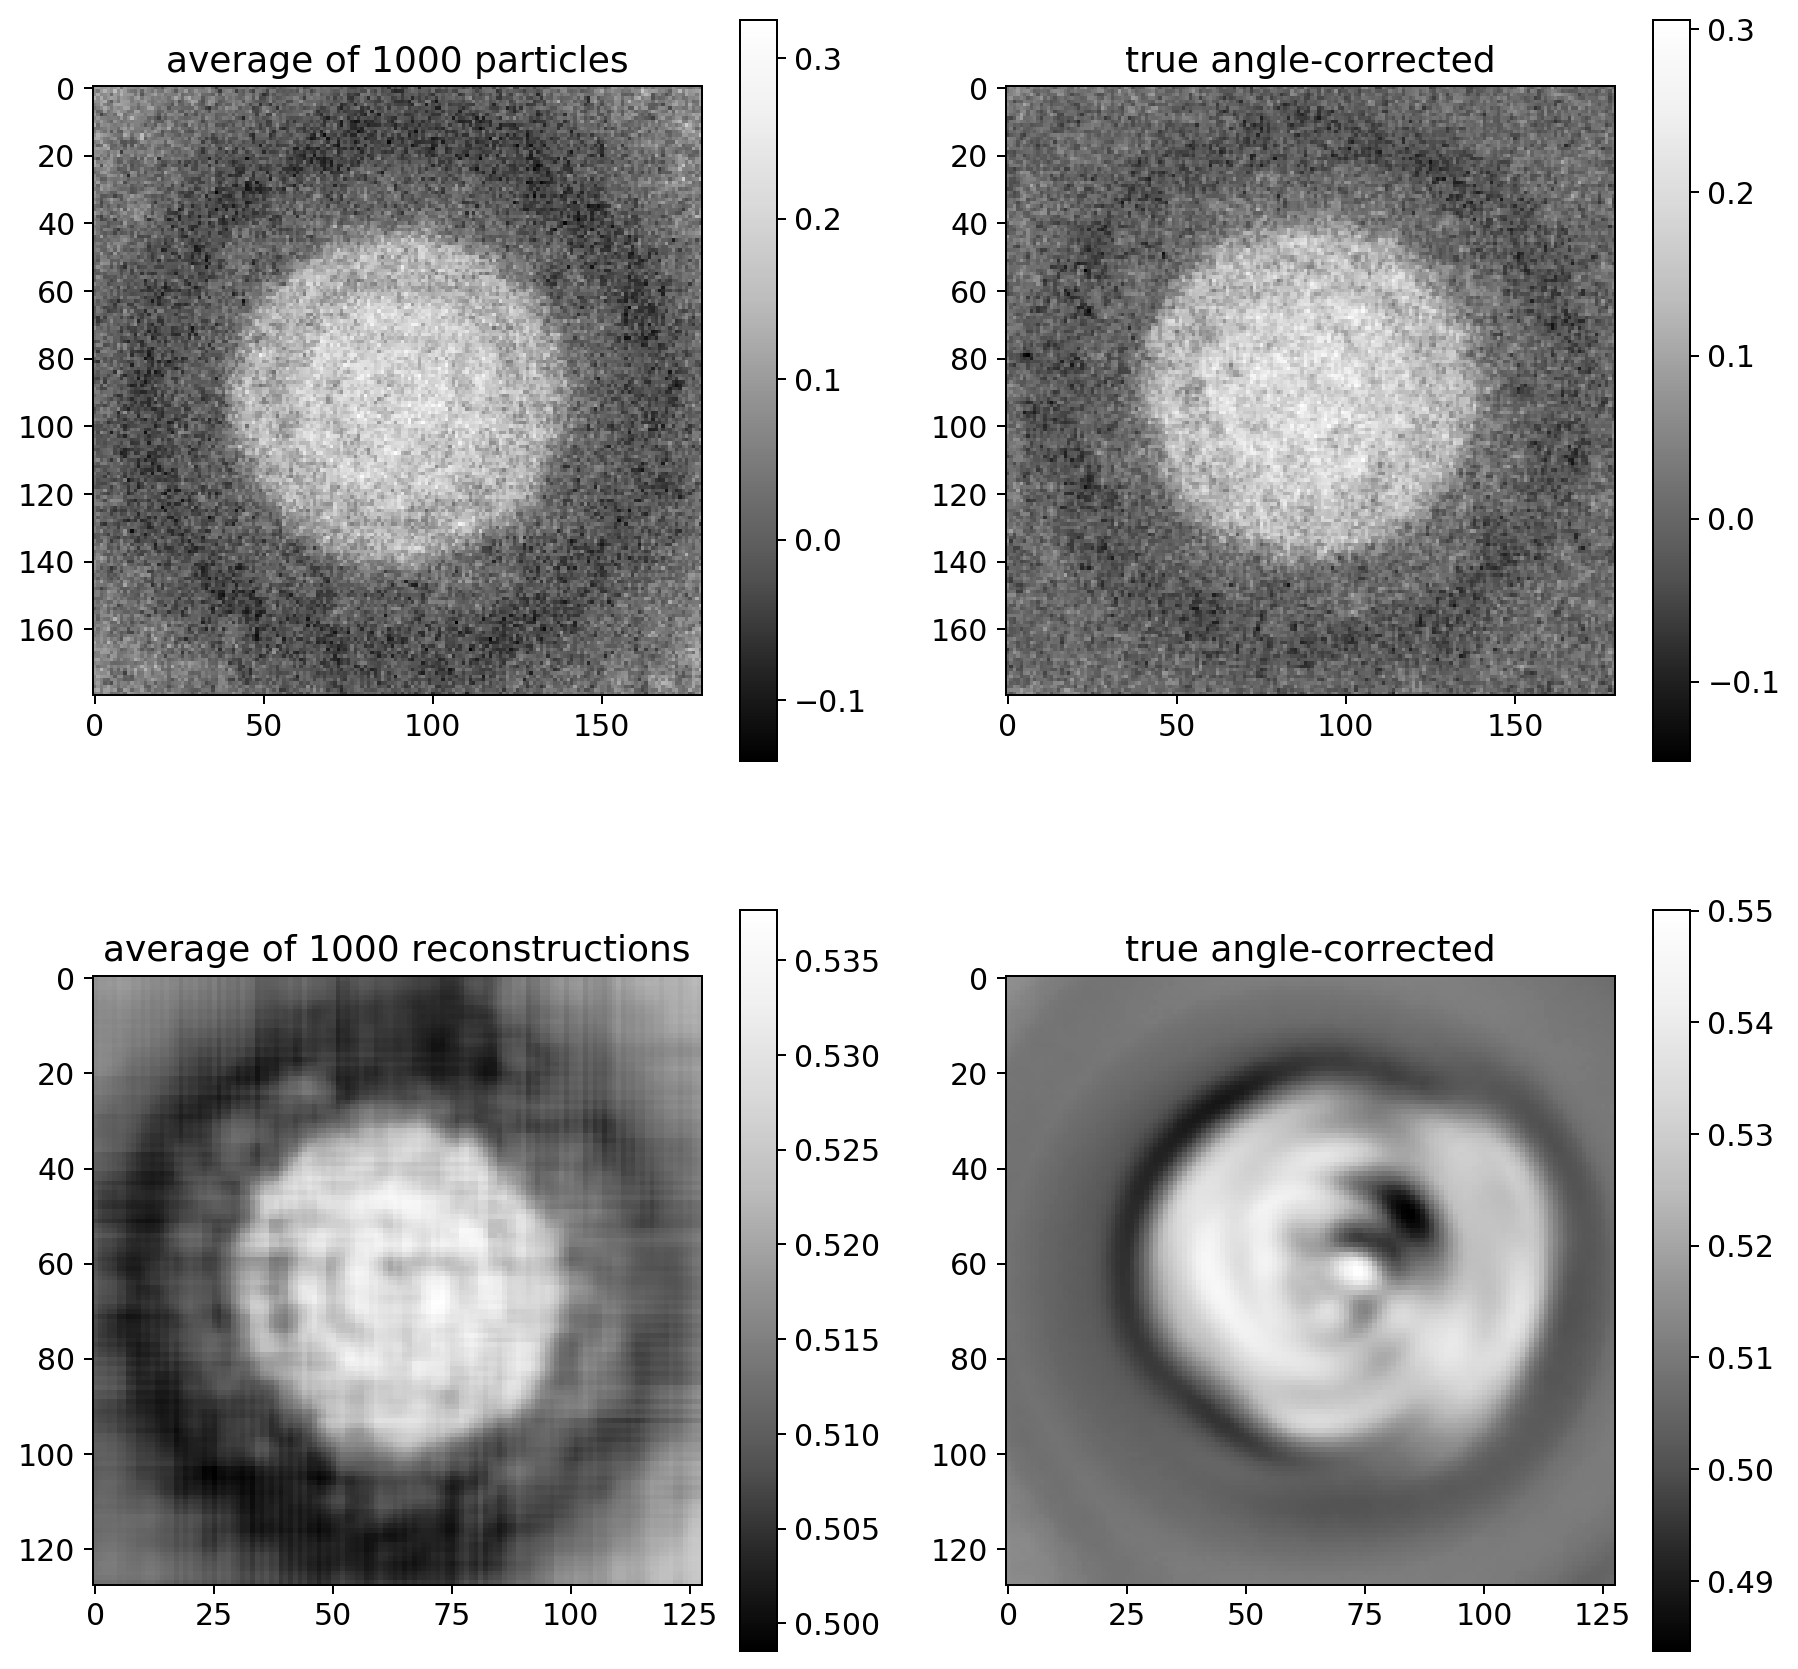

In [89]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true angle-corrected')
plt.imshow(np.mean(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true angle-corrected')
plt.imshow(np.mean(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

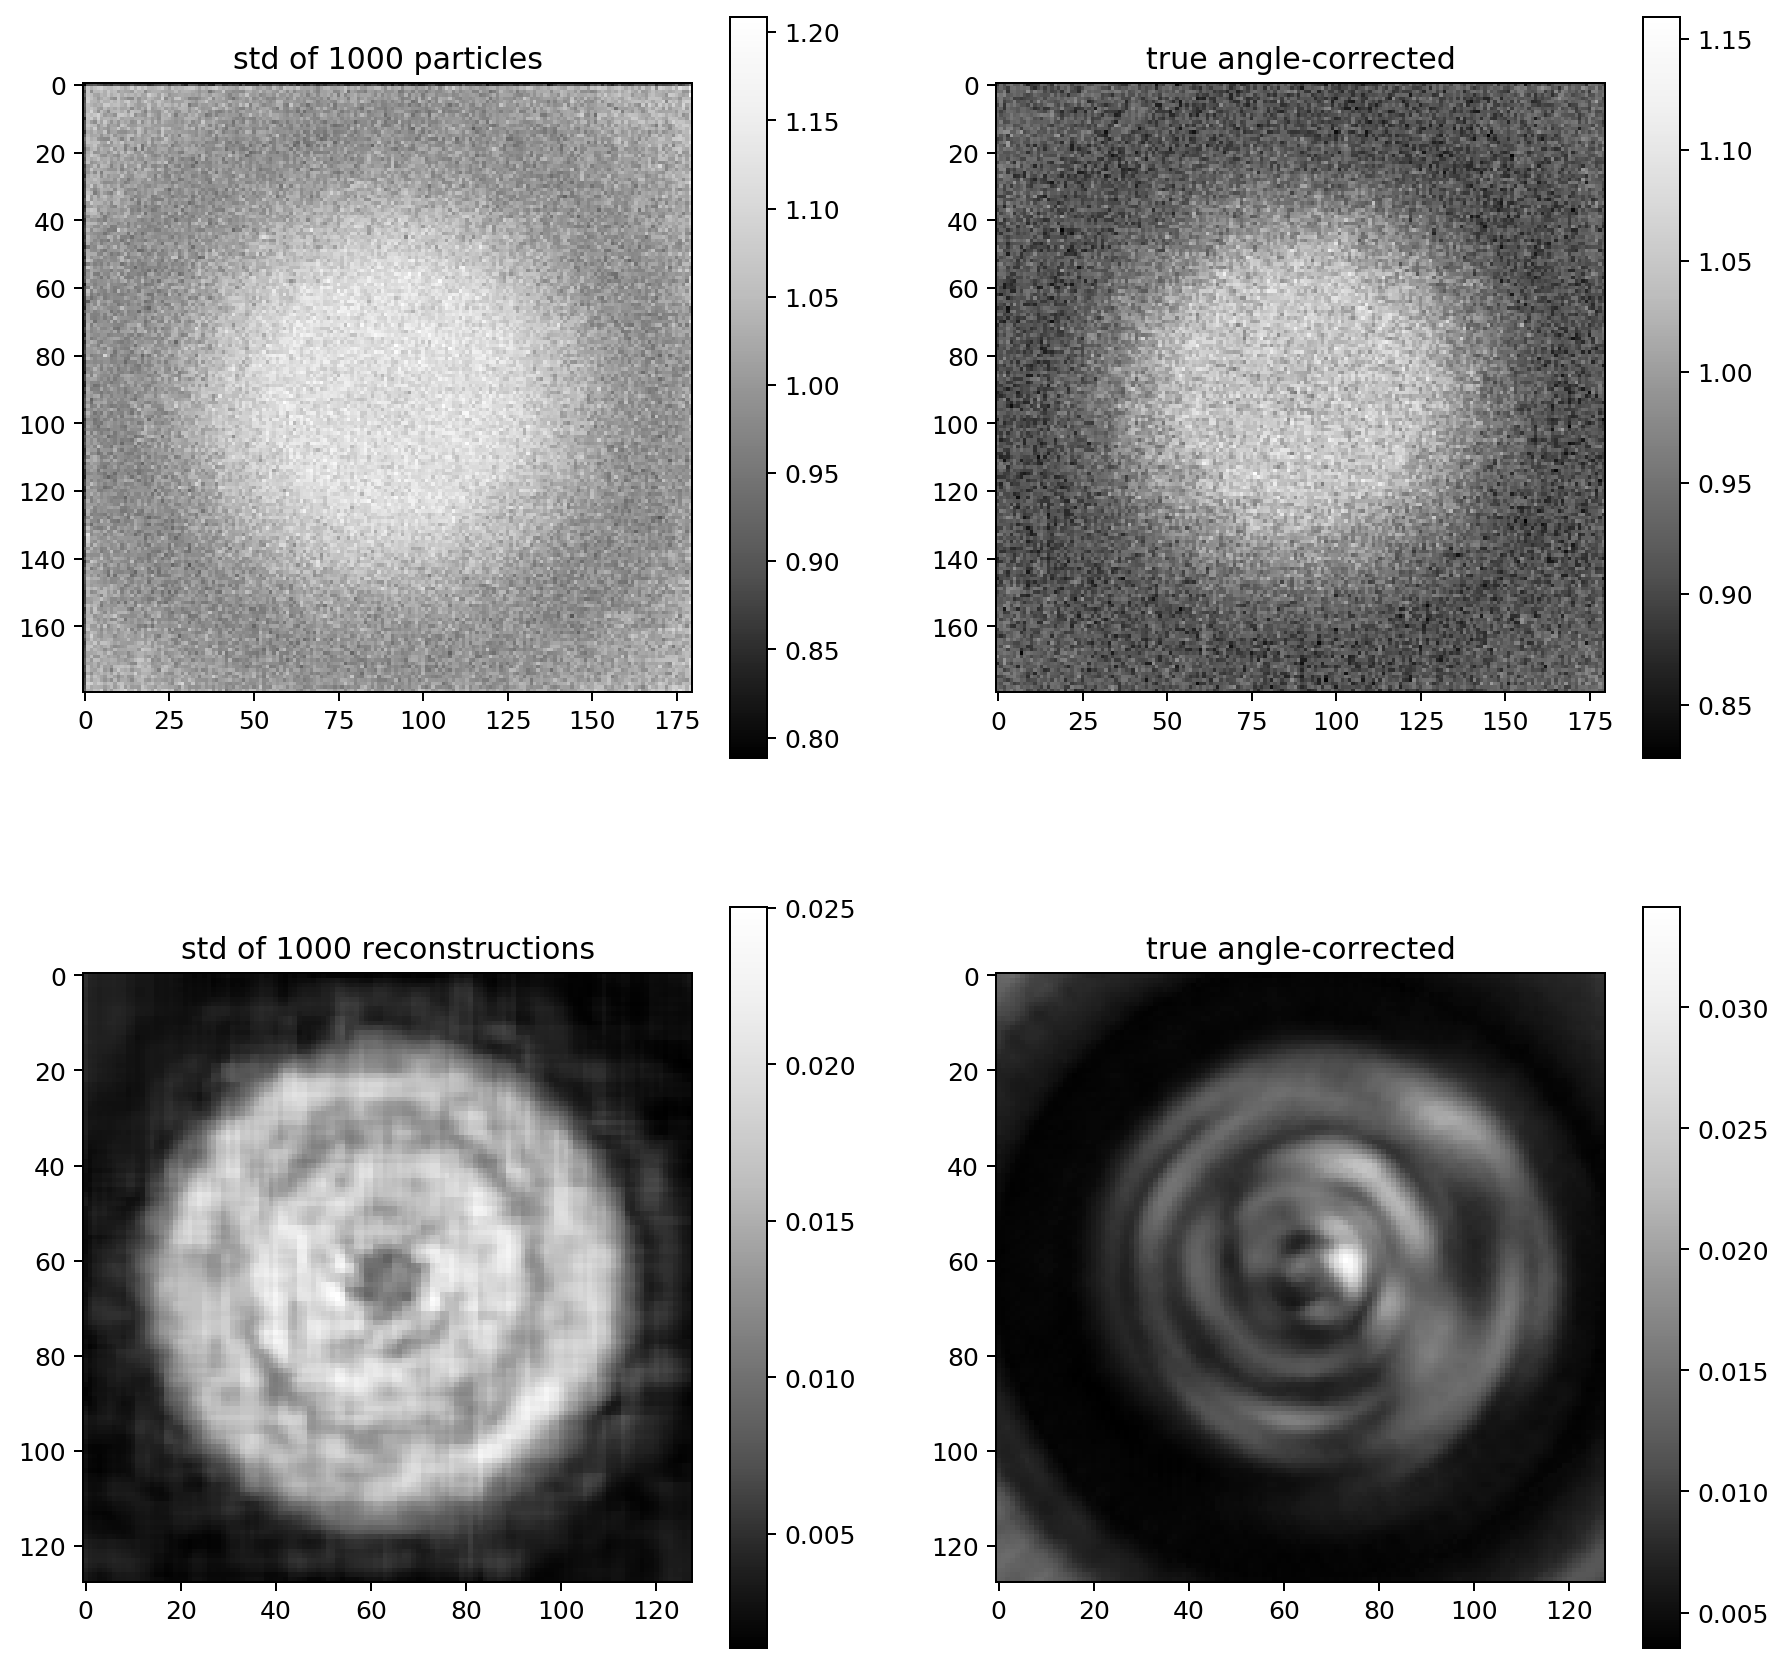

In [22]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('std of 1000 particles')
plt.imshow(np.std(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true angle-corrected')
plt.imshow(np.std(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('std of 1000 reconstructions')
plt.imshow(np.std(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true angle-corrected')
plt.imshow(np.std(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

In [42]:
from scipy.ndimage import rotate
recon_rot = np.zeros(recon.shape)
particles_rot = np.zeros(particles_dataset.shape)
for i in np.arange(1000):
    #print(i,angle_curated[i])
    recon_rot[i,0,:,:] = rotate(recon[i,0,:,:],angle=-angle_pred[i],axes=(0,1),mode='wrap', reshape=False) 
    particles_rot[i,0,:,:] = rotate(particles_dataset[i,0,:,:],angle=-angle_pred[i],axes=(0,1), mode='wrap', reshape=False) 

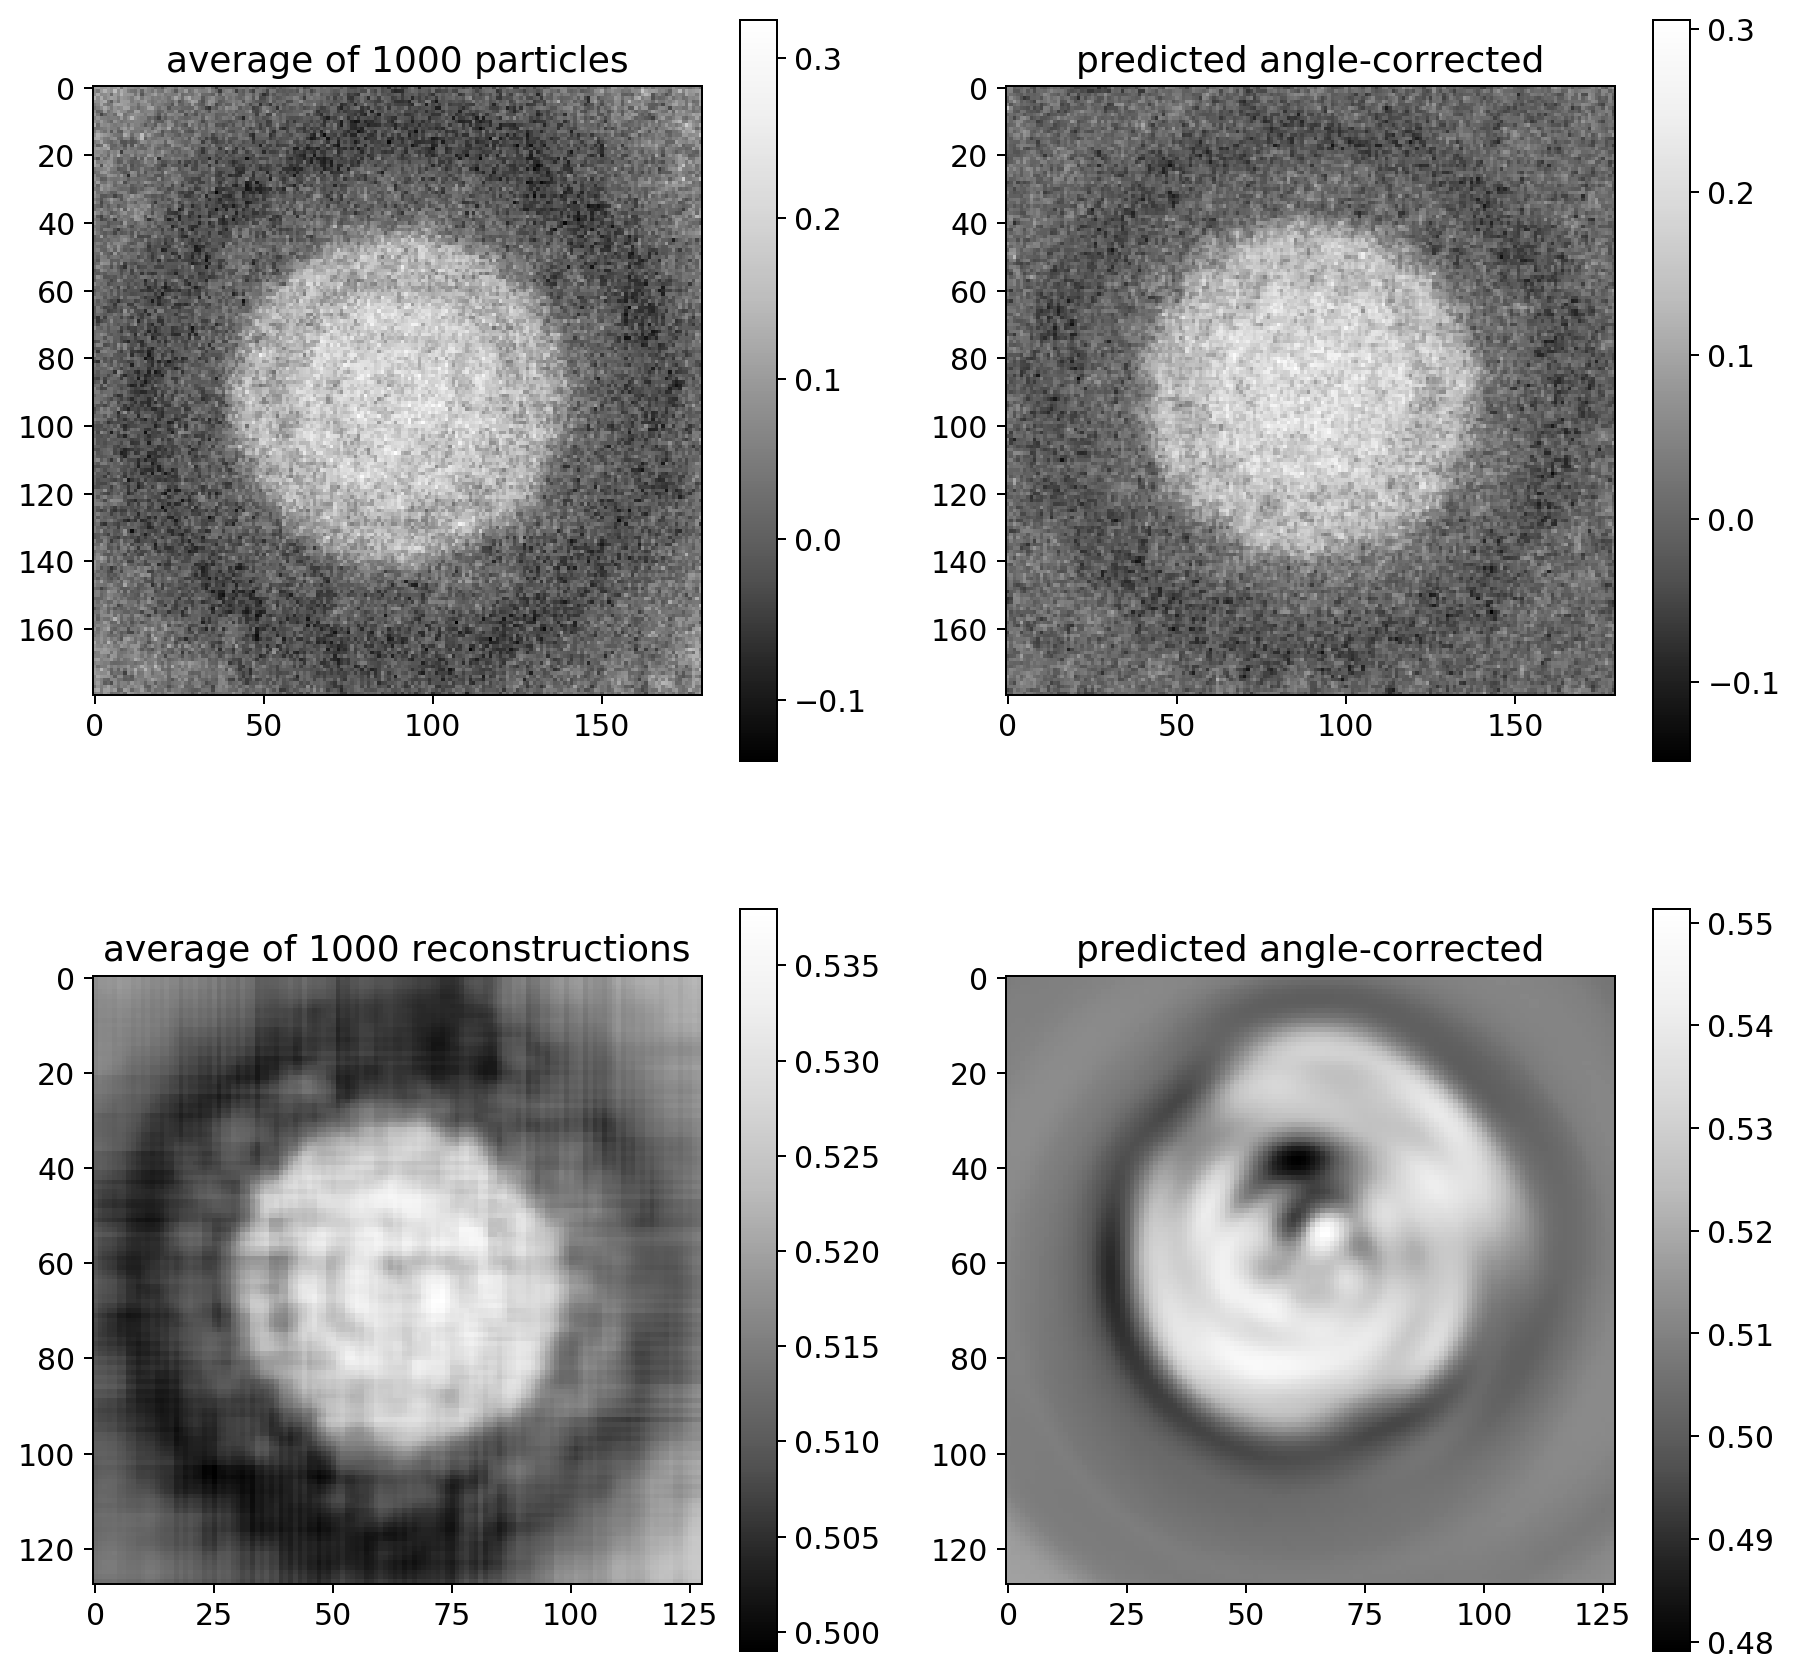

In [44]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('predicted angle-corrected')
plt.imshow(np.mean(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('predicted angle-corrected')
plt.imshow(np.mean(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

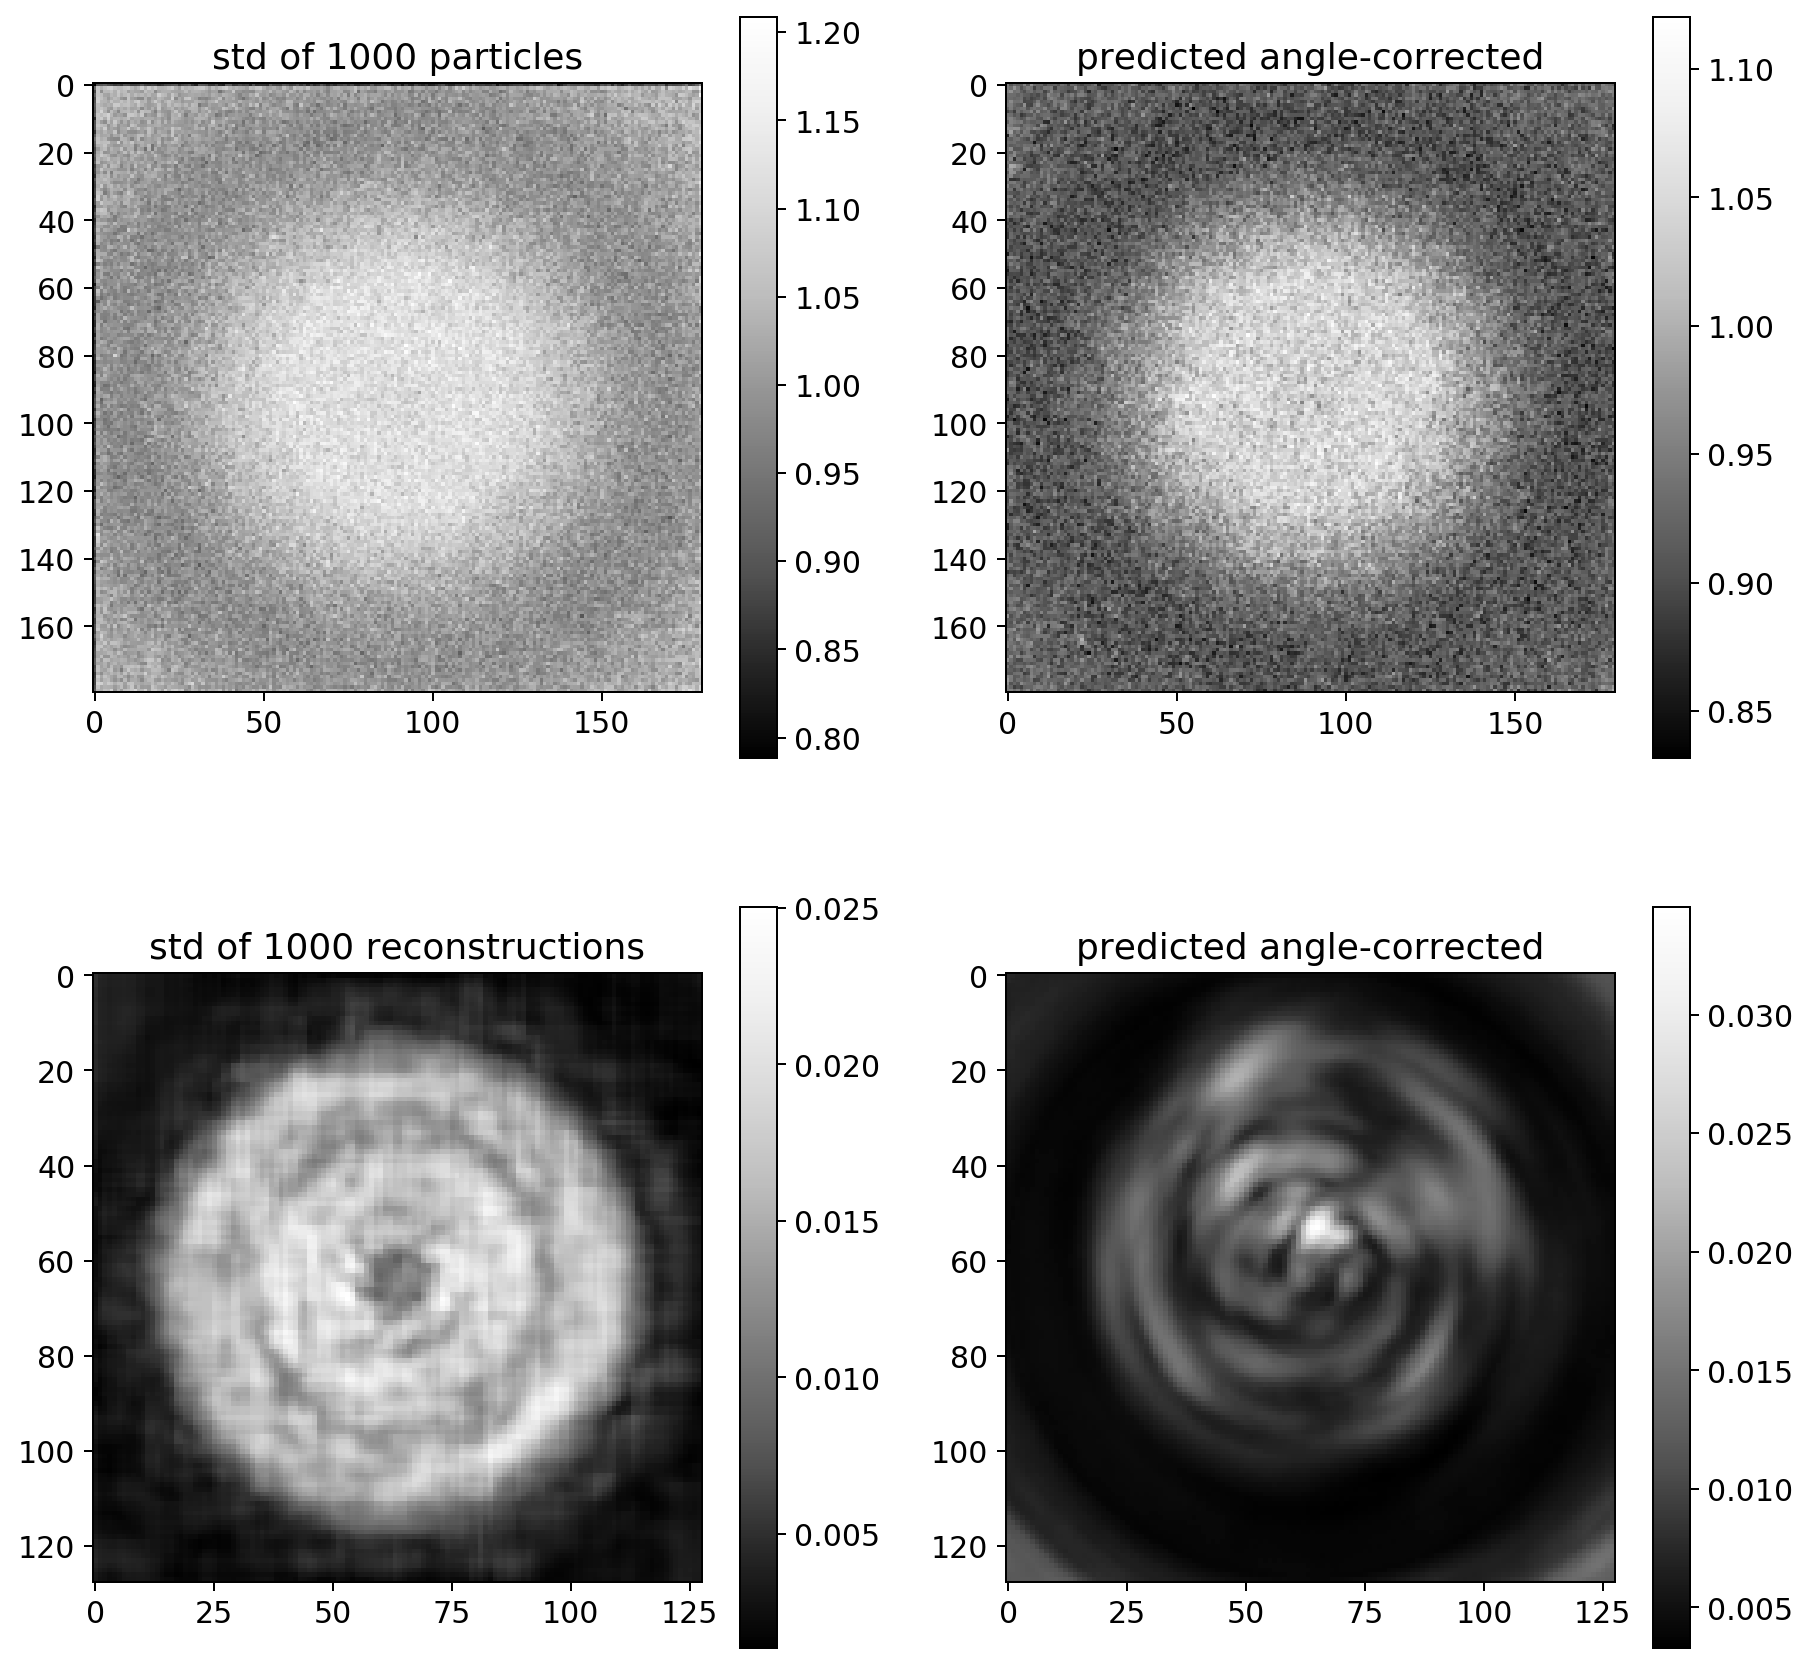

In [45]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('std of 1000 particles')
plt.imshow(np.std(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('predicted angle-corrected')
plt.imshow(np.std(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('std of 1000 reconstructions')
plt.imshow(np.std(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('predicted angle-corrected')
plt.imshow(np.std(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()

### need to do translations ?

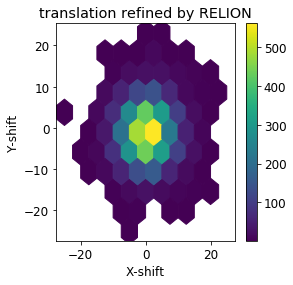

In [71]:
fig = plt.figure(figsize=(4,4))
plt.title('translation refined by RELION')
tx = np.array(metadata['_rlnoriginx'])
plt.xlabel('X-shift')
ty = np.array(metadata['_rlnoriginy'])
plt.ylabel('Y-shift')
plt.hexbin(tx,ty,mincnt=1,gridsize=10)
plt.colorbar()
tx_curated = tx
ty_curated = ty

In [99]:
from scipy.ndimage import rotate, shift
recon_rot = np.zeros(recon.shape)
particles_rot = np.zeros(particles_dataset.shape)
for i in np.arange(1000):
    particle       = particles_dataset[i,0,:,:]
    #reconstruction = recon[i,0,:,:]
    particle_shift = shift(particle, shift=((-tx_curated[i],-ty_curated[i])),mode='wrap')
    recon_shift    = shift(reconstruction, shift=((-tx_curated[i],-ty_curated[i])),mode='wrap')
    recon_rot[i,0,:,:]     = rotate(recon_shift,angle=-angle_curated[i],axes=(0,1),mode='wrap', reshape=False) 
    particles_rot[i,0,:,:] = rotate(particle_shift,angle=-angle_curated[i],axes=(0,1), mode='wrap', reshape=False) 

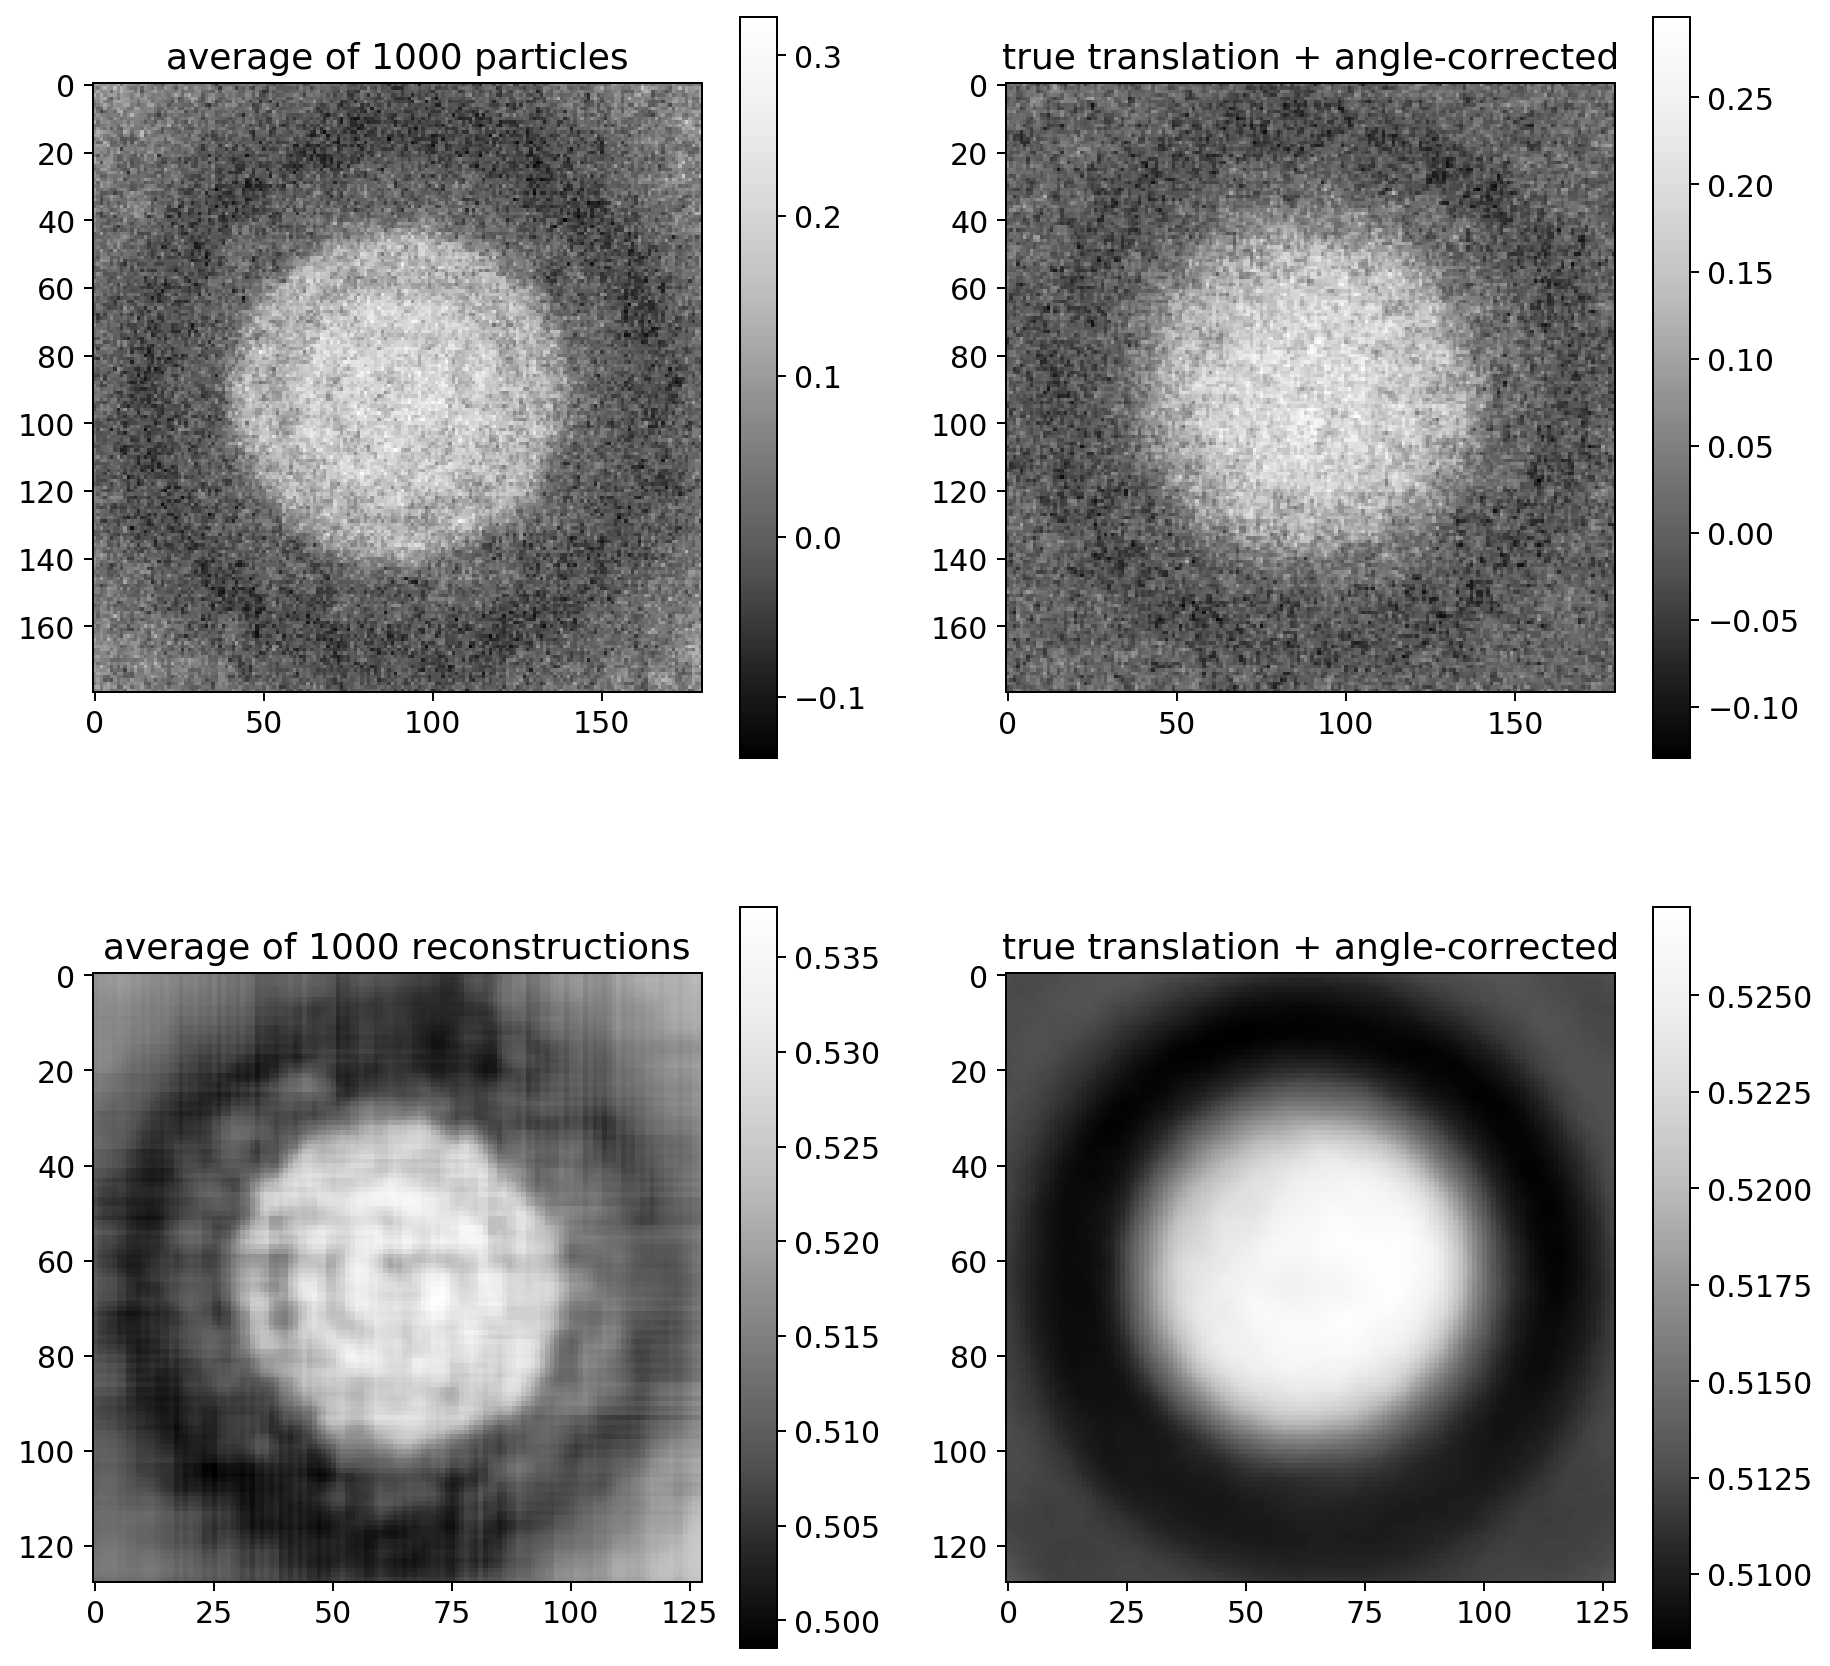

In [101]:
n=1000
fig = plt.figure(figsize=(12,12),dpi=180)
plt.subplot(2,2,1)
plt.title('average of 1000 particles')
plt.imshow(np.mean(particles_dataset[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('true translation + angle-corrected')
plt.imshow(np.mean(particles_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,3)
plt.title('average of 1000 reconstructions')
plt.imshow(np.mean(recon[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()
plt.subplot(2,2,4)
plt.title('true translation + angle-corrected')
plt.imshow(np.mean(recon_rot[0:n,0,:,:],axis=0), cmap='Greys_r')
plt.colorbar()